In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
from matplotlib import font_manager, rc
import matplotlib

# 한글 폰트 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # 경로는 사용 환경에 따라 다를 수 있음
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

matplotlib.rcParams['axes.unicode_minus'] = False  # False로 설정하면 음수 기호가 정상 출력됨

In [3]:
submission = pd.read_csv('data/submission.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 수치형 변수 시각화

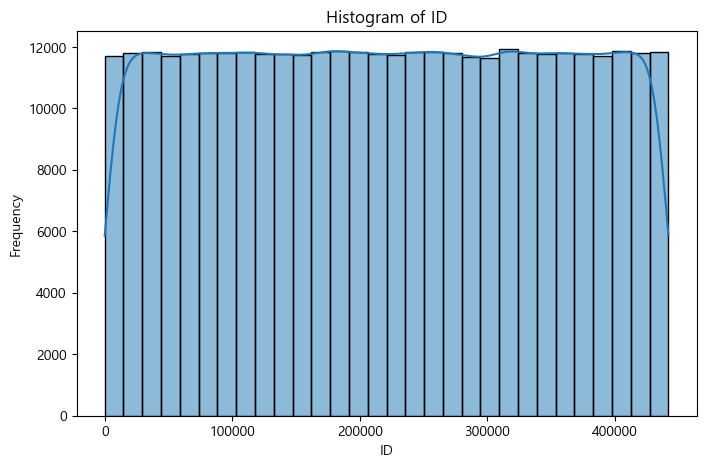

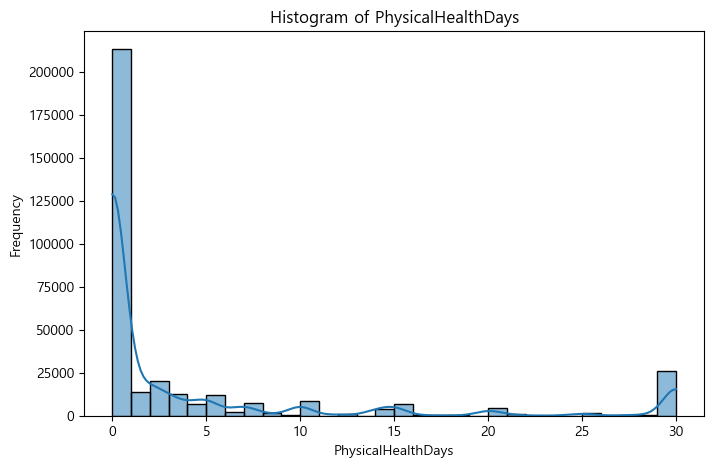

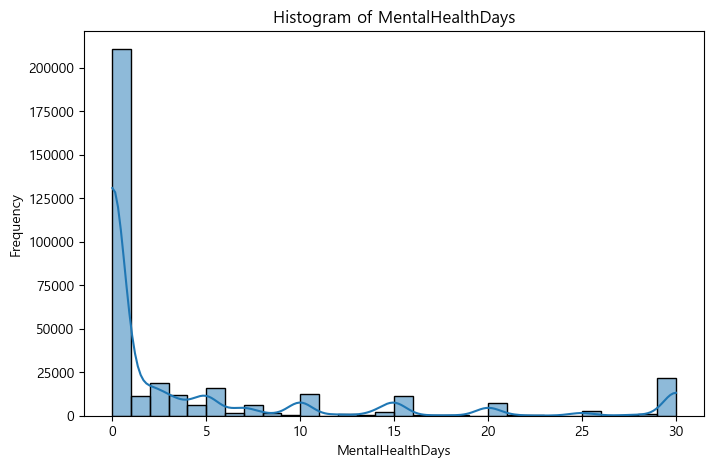

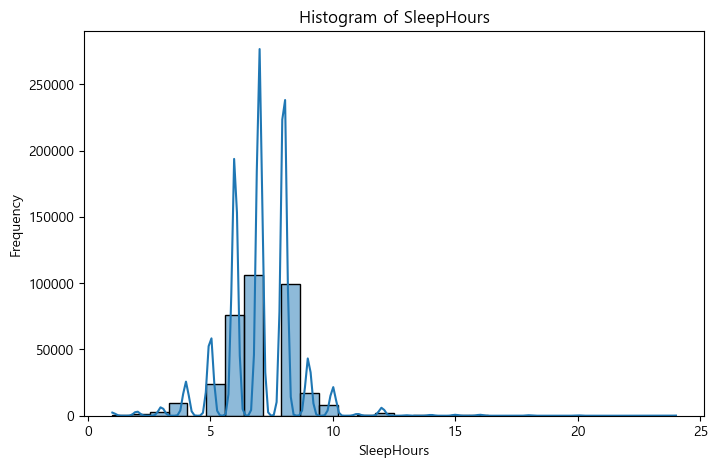

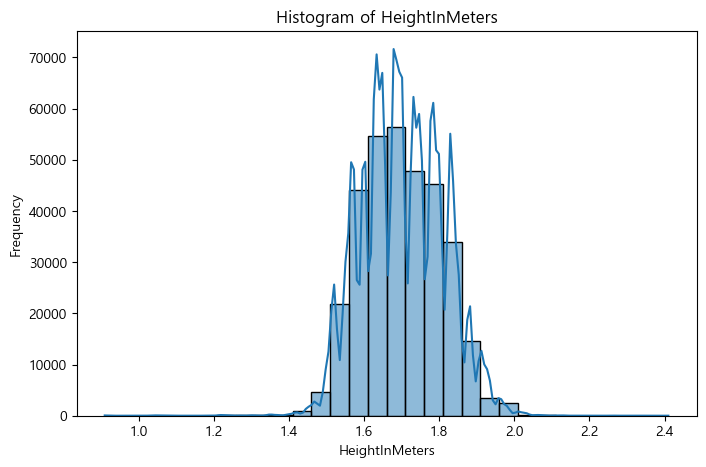

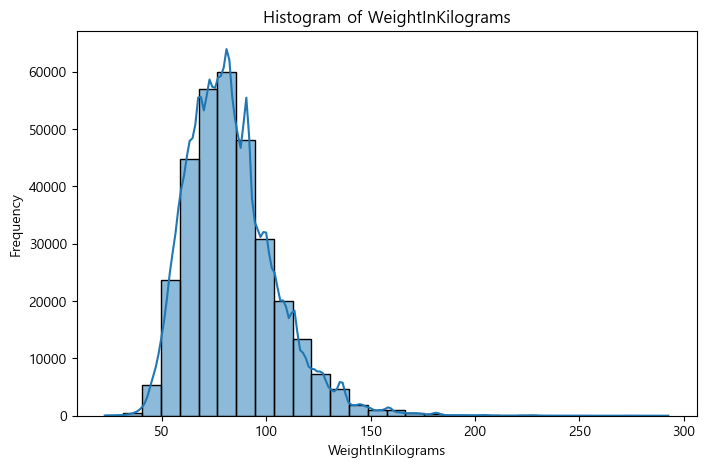

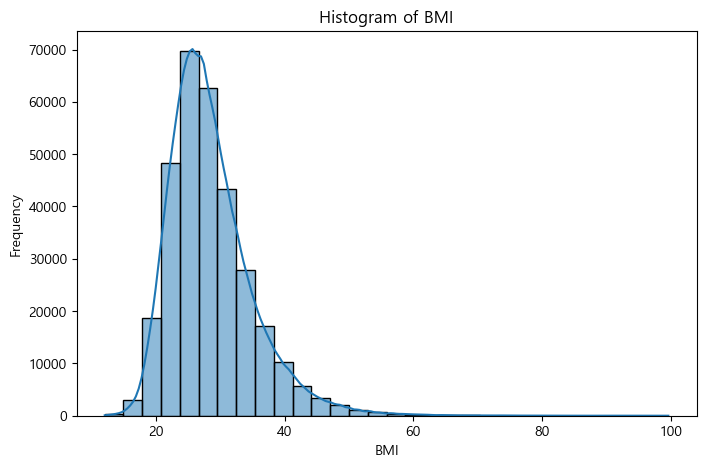

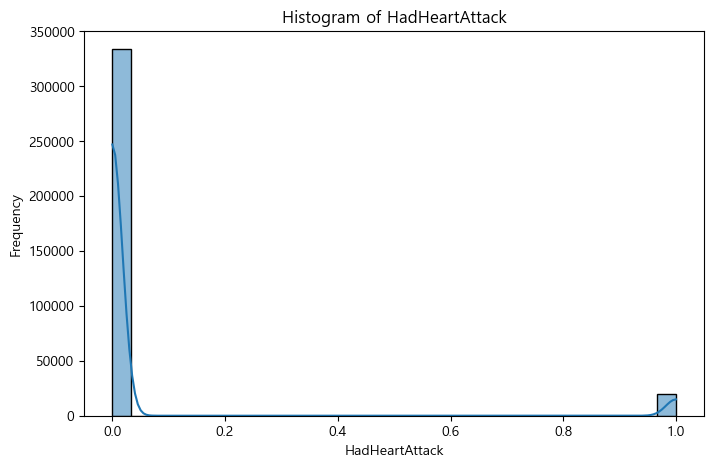

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in train.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 수치형 변수들 끼리의 상관관계 파악
- BMI와 WeightInKilograms의 상관관계가 높다는 것을 확인할 수 있음 -> 다중공산성 제거 해야 함을 어필 가능

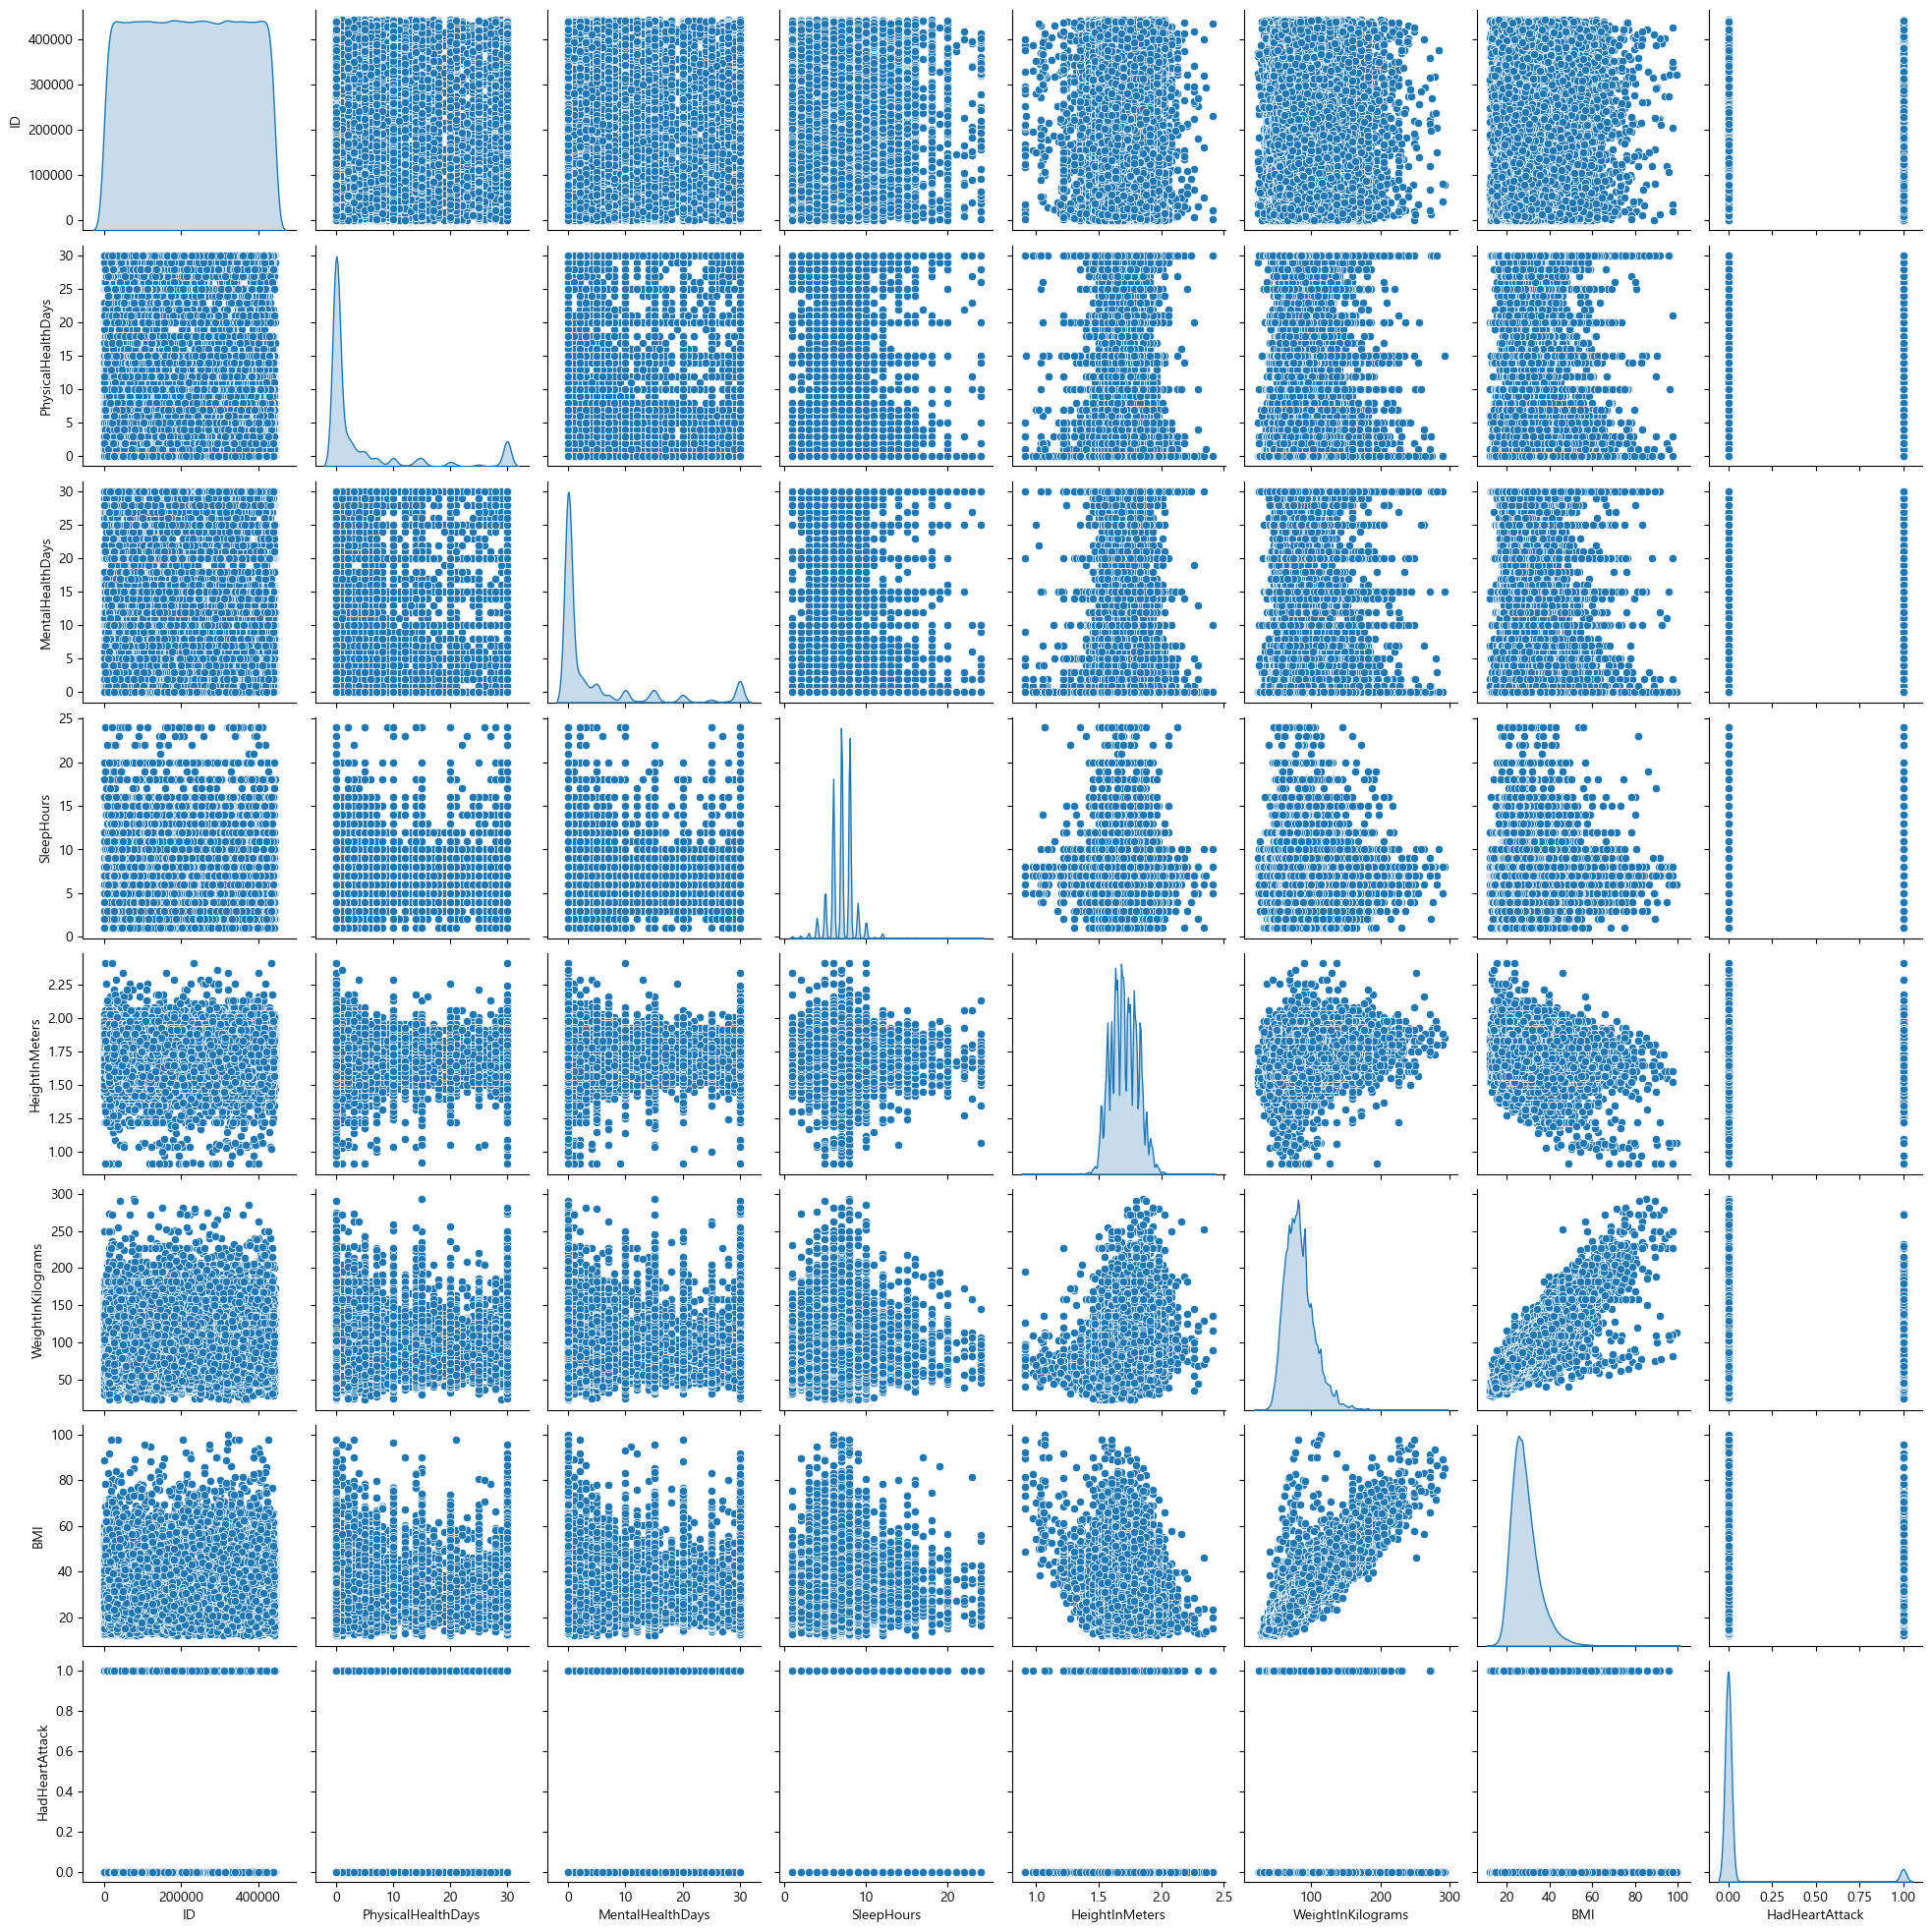

In [ ]:
# 오래걸리니까 돌리지 마세요!(ppt용)
'''
sns.pairplot(train.select_dtypes(include=['float64', 'int64']), diag_kind='kde')
plt.show()
'''

# 범주형 변수 시각화

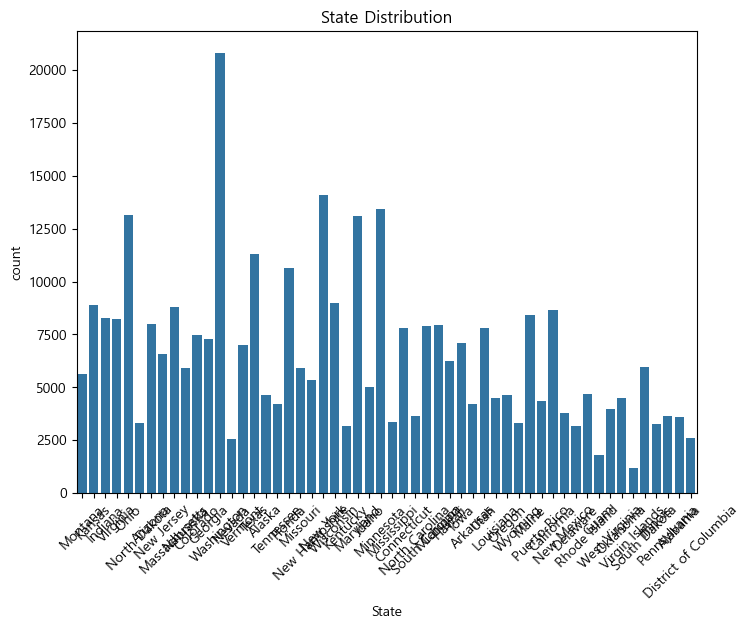

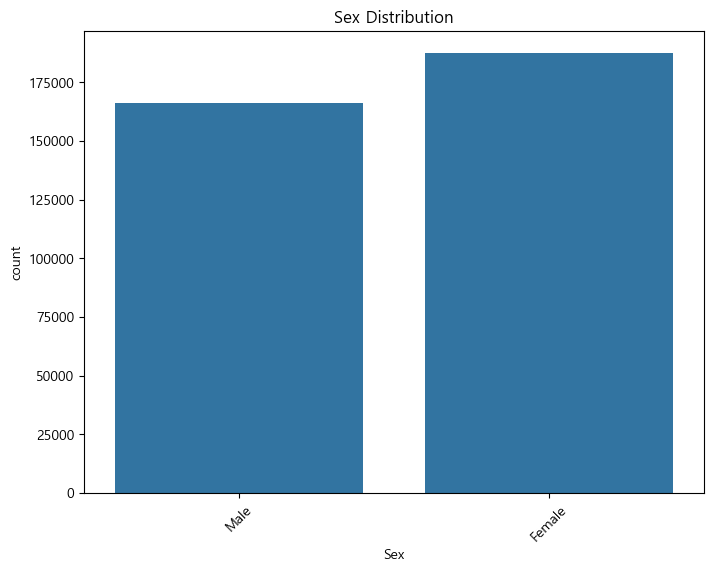

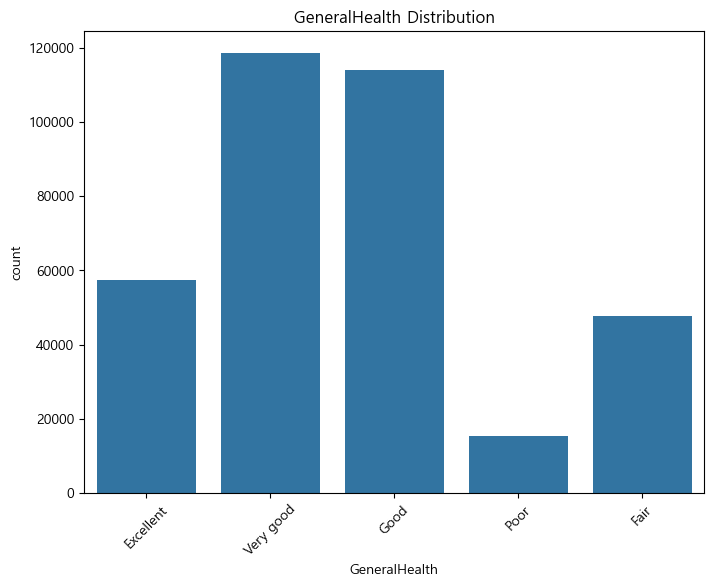

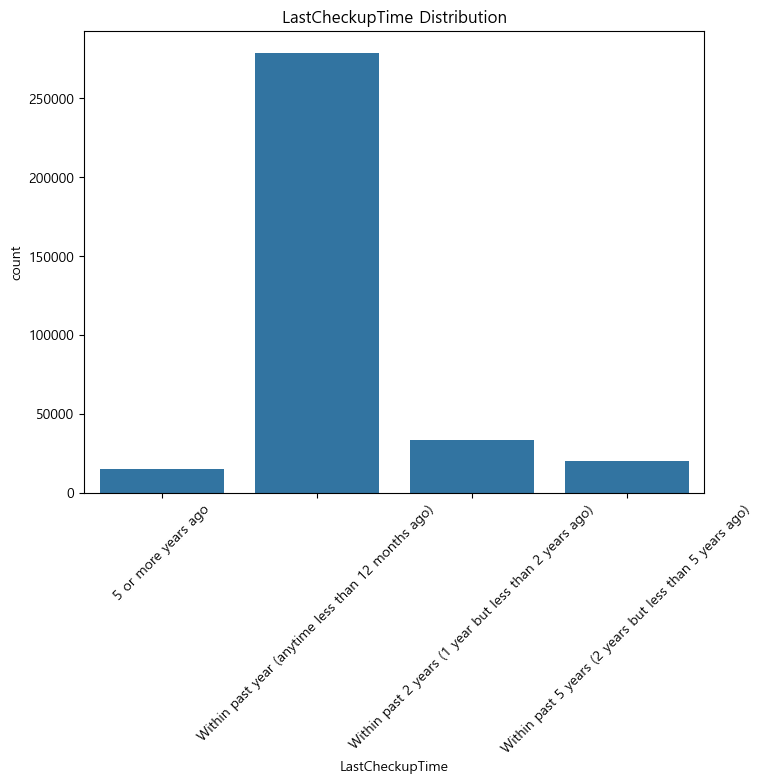

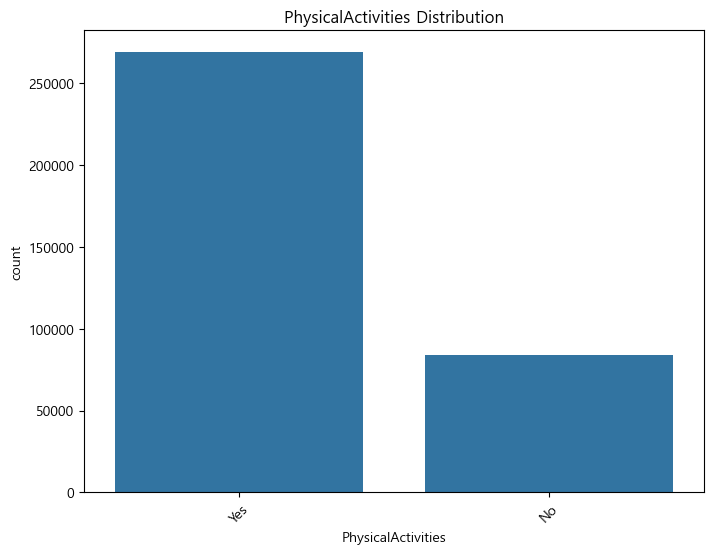

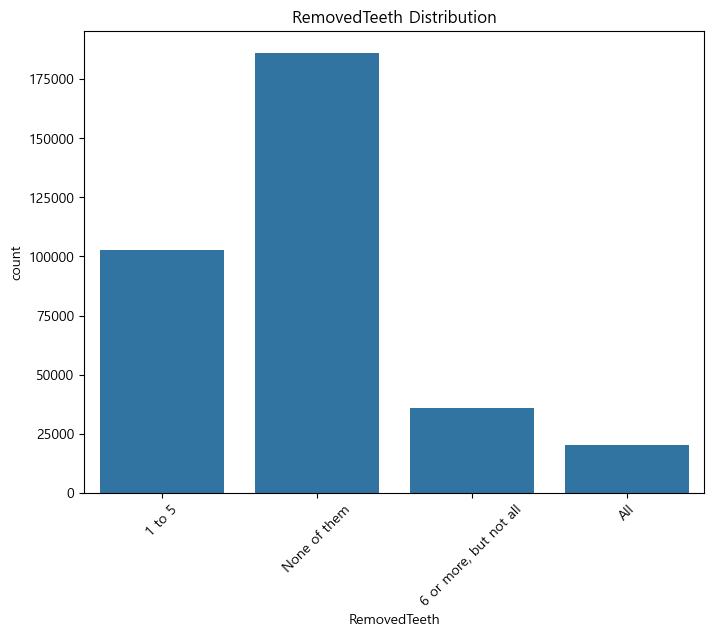

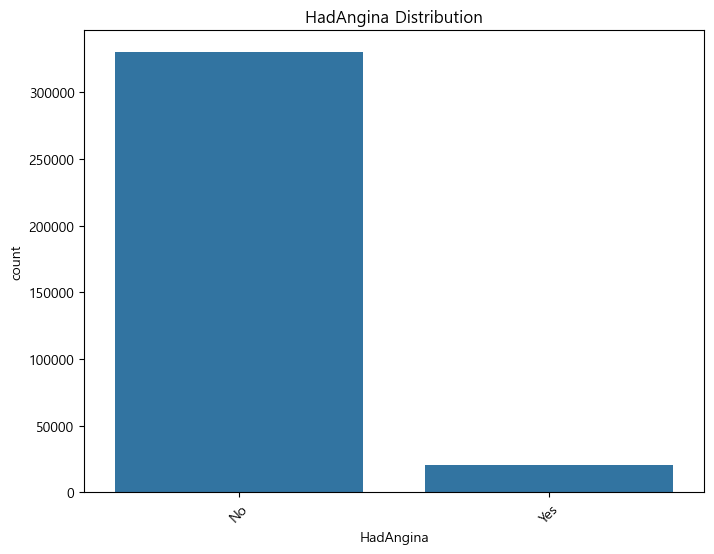

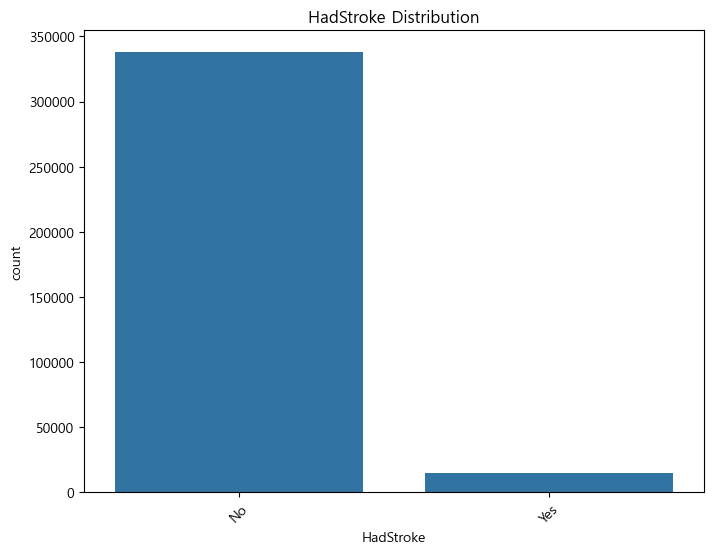

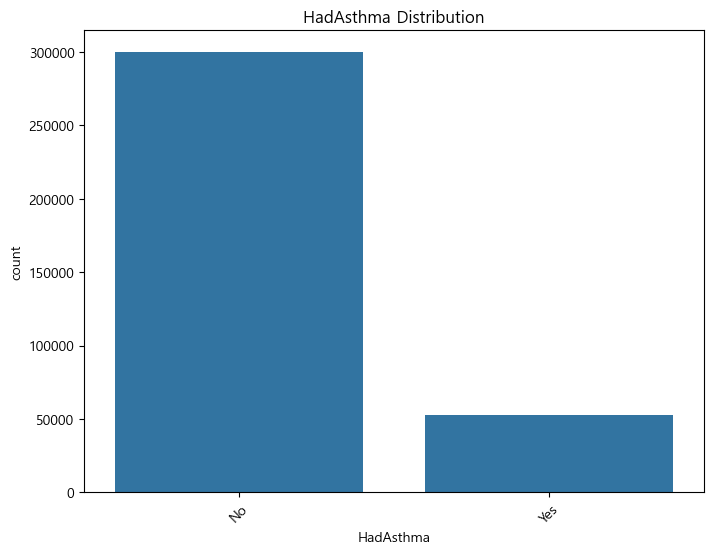

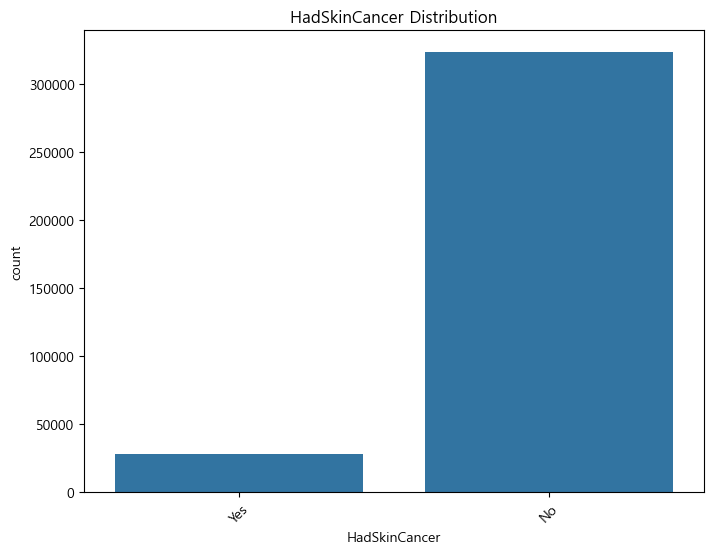

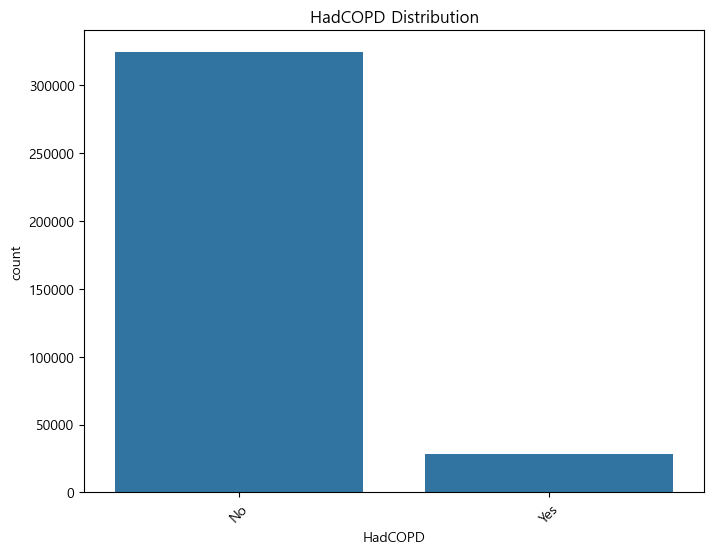

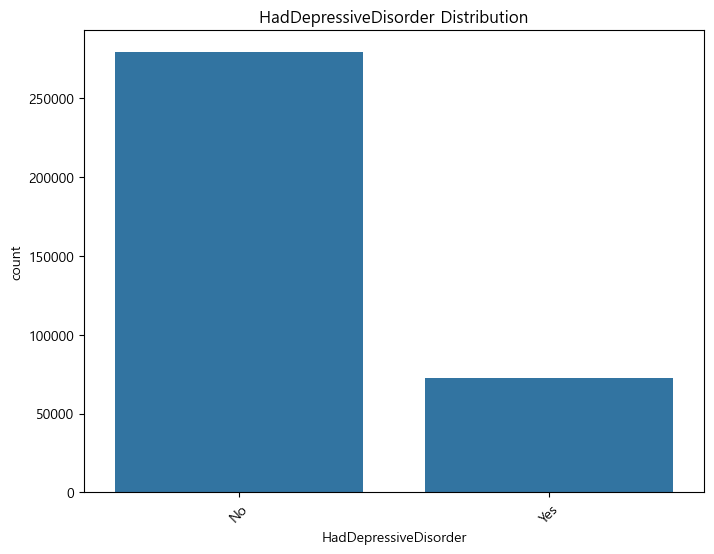

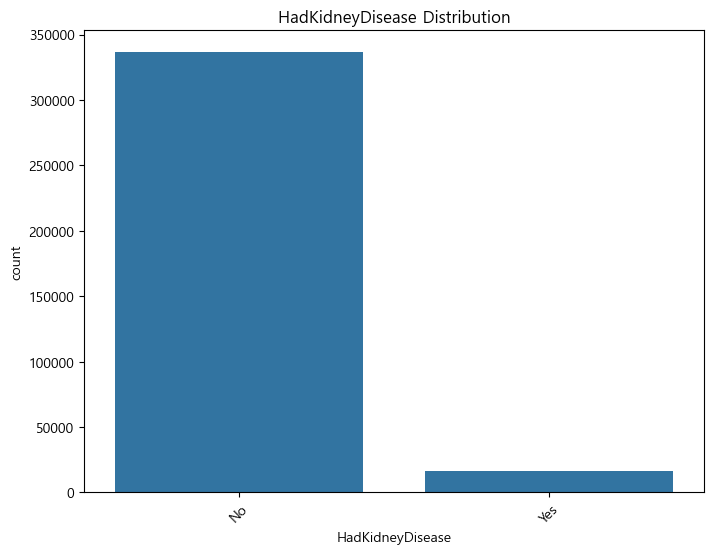

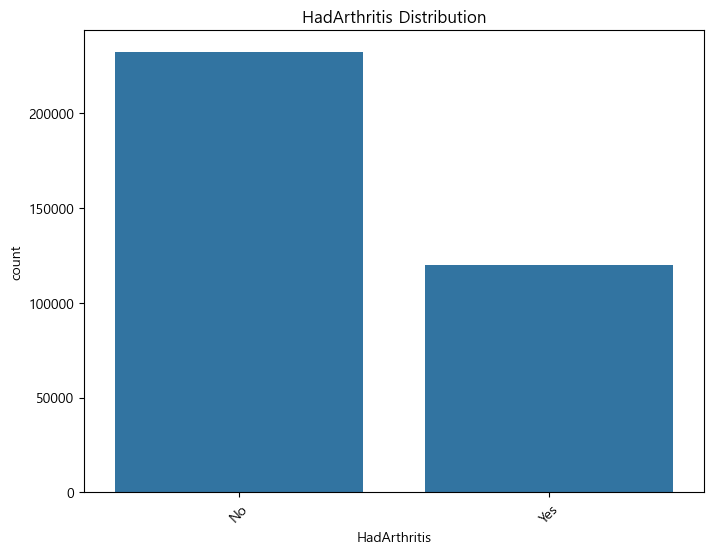

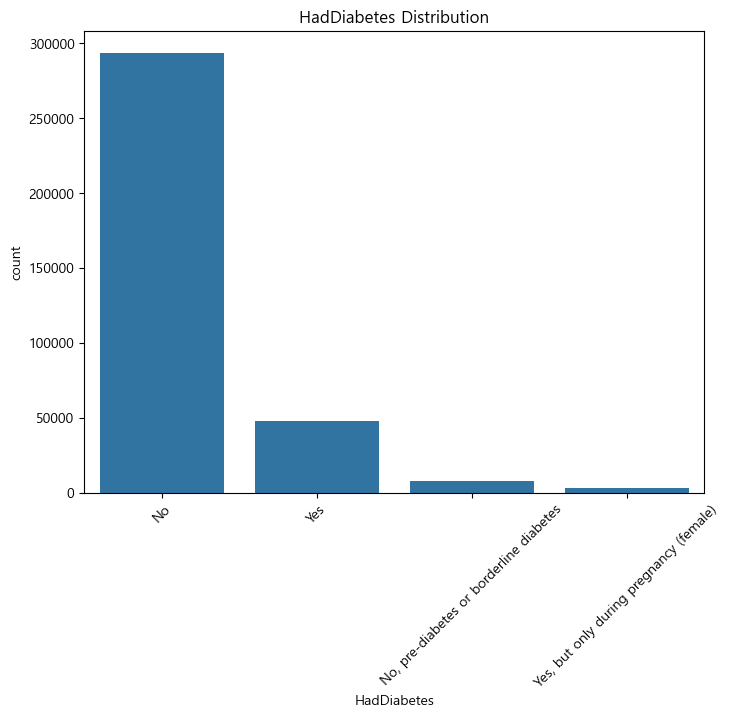

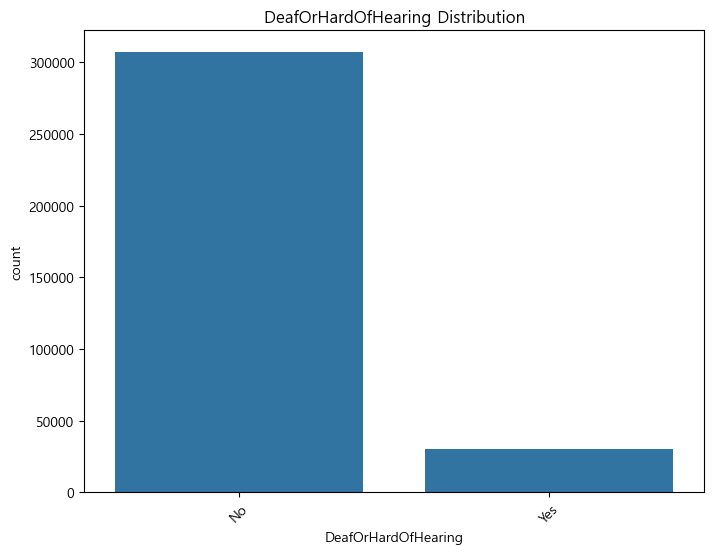

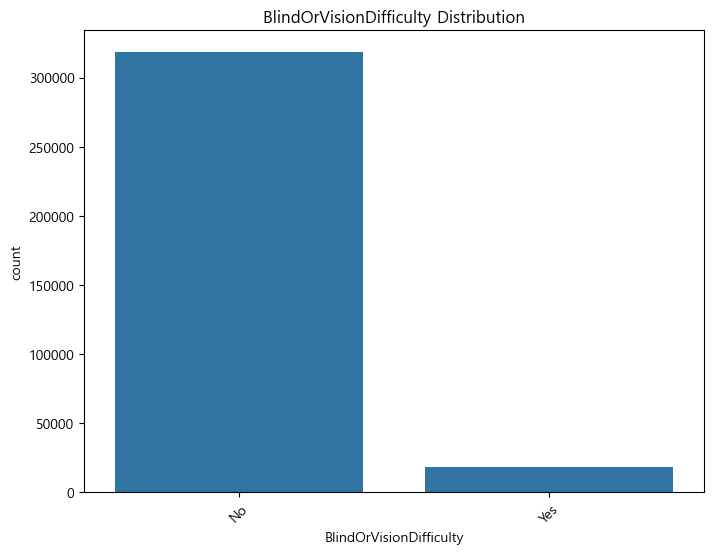

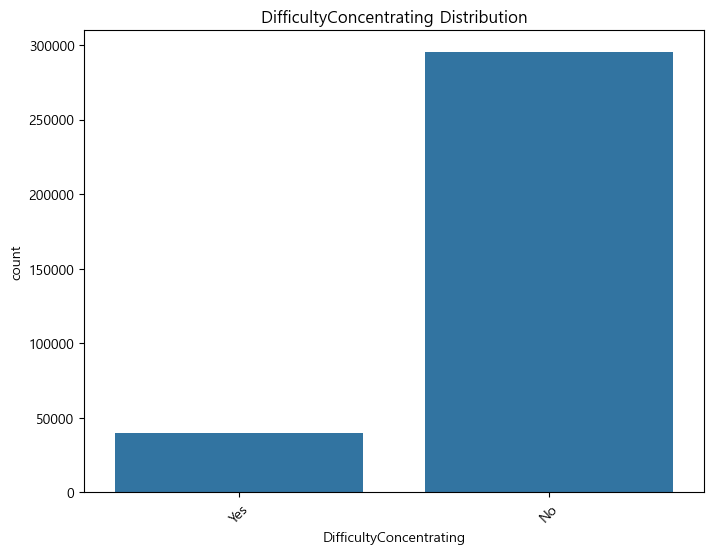

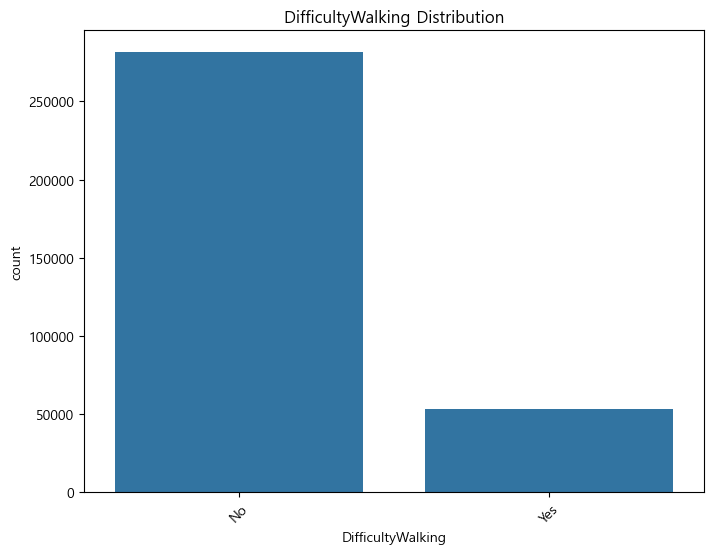

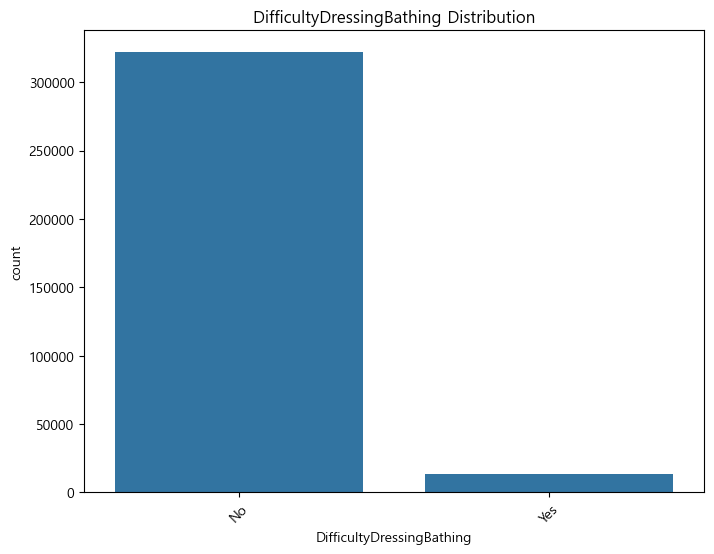

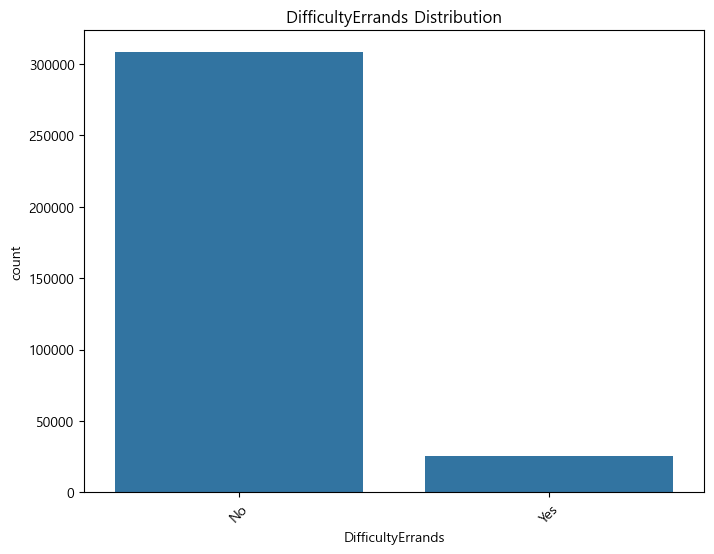

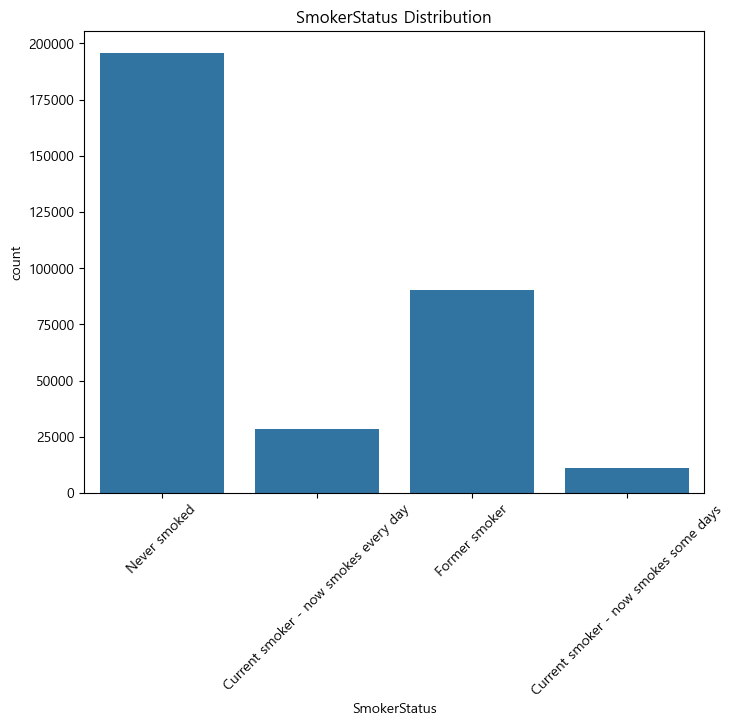

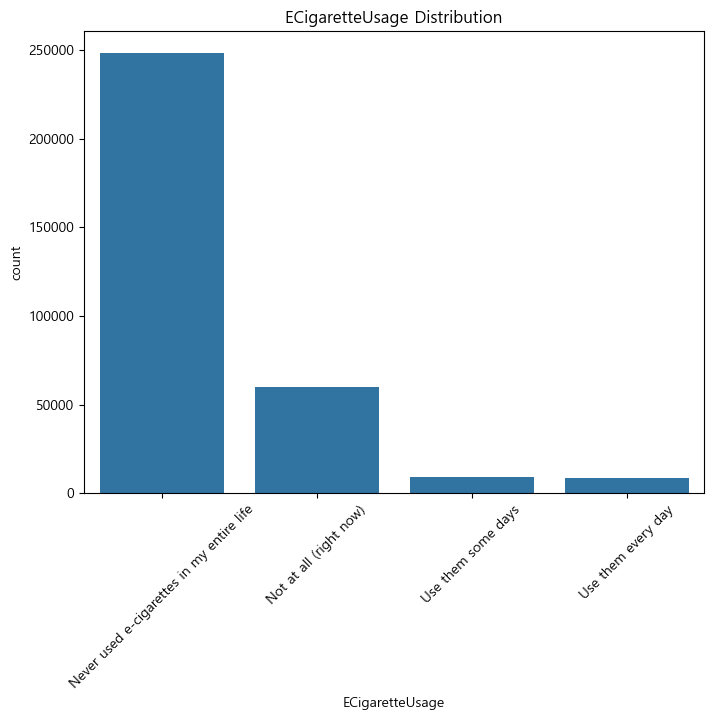

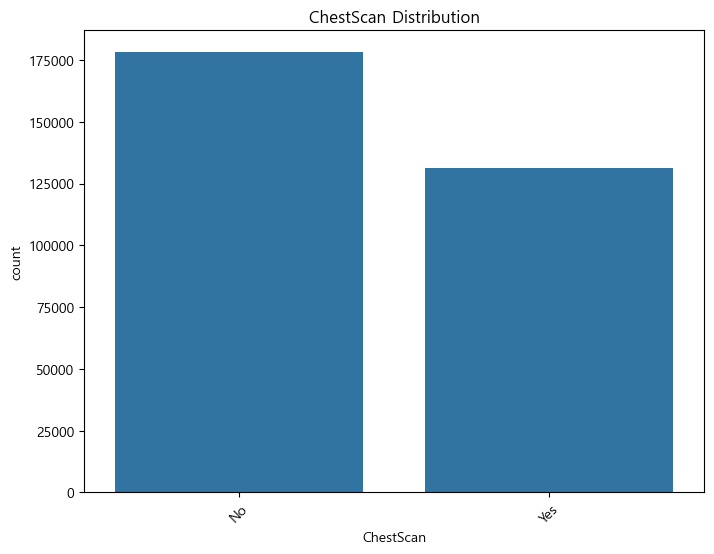

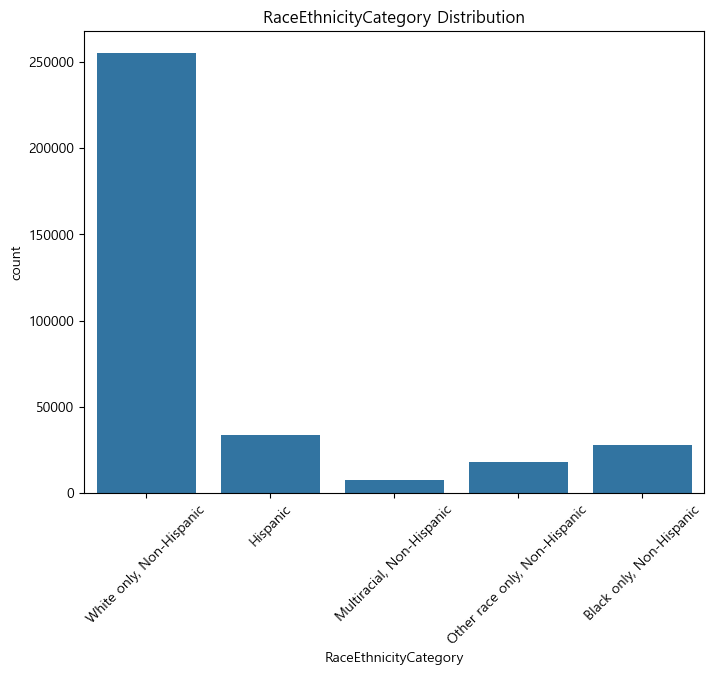

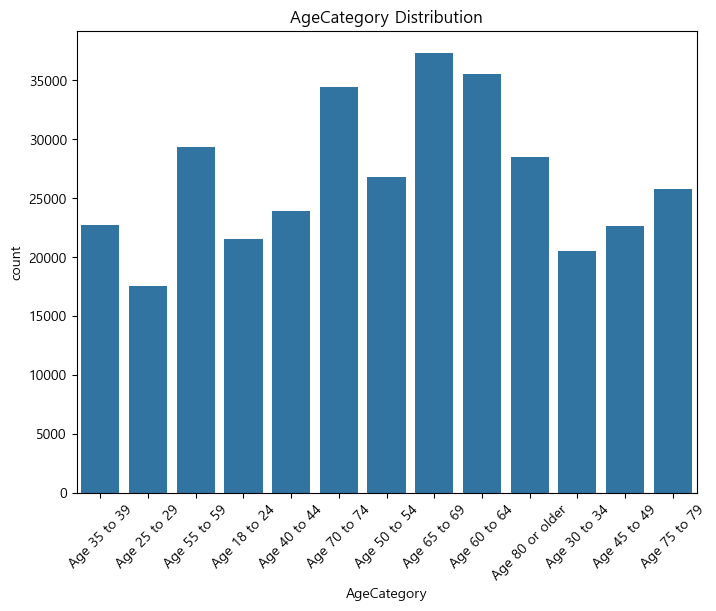

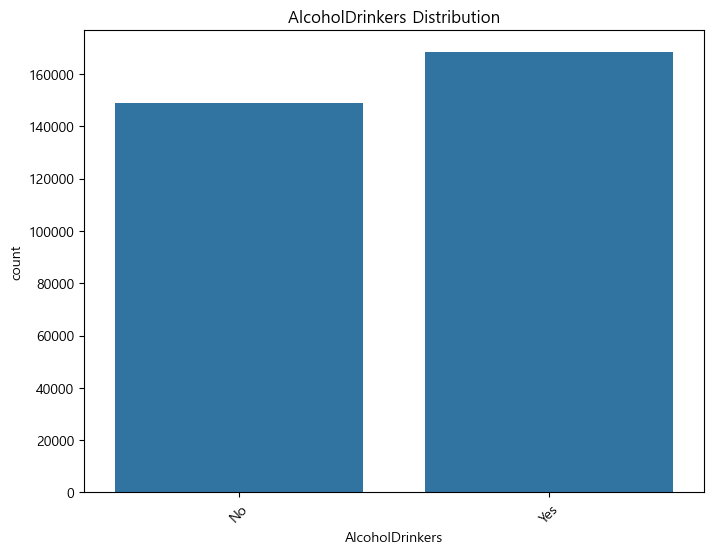

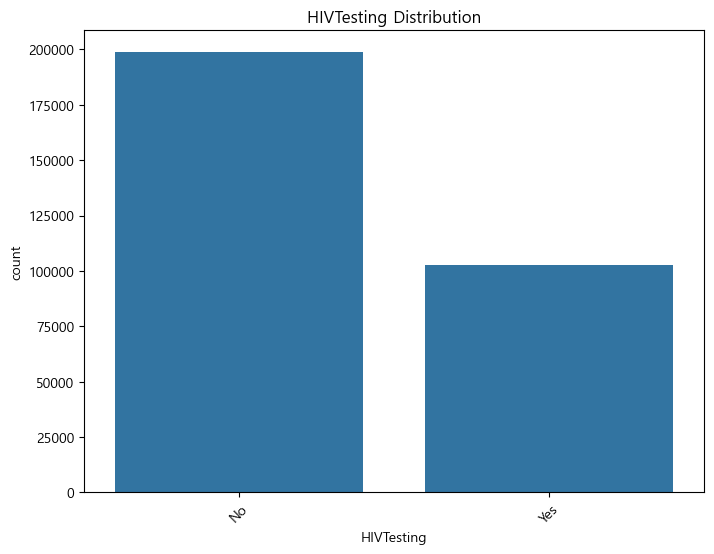

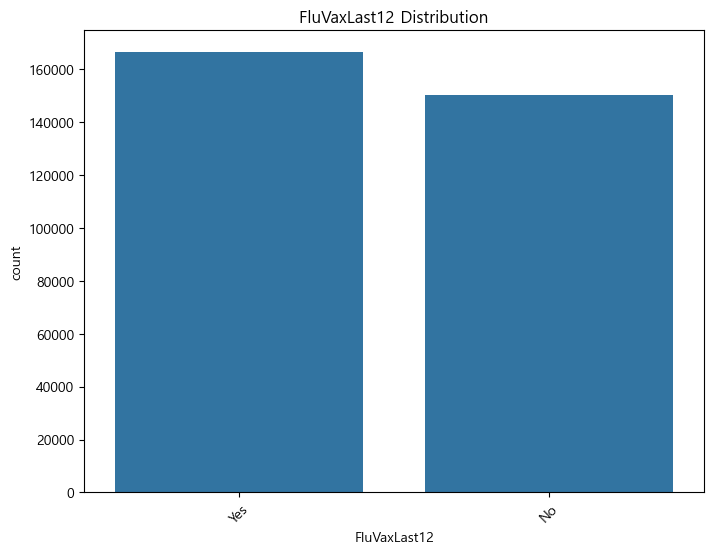

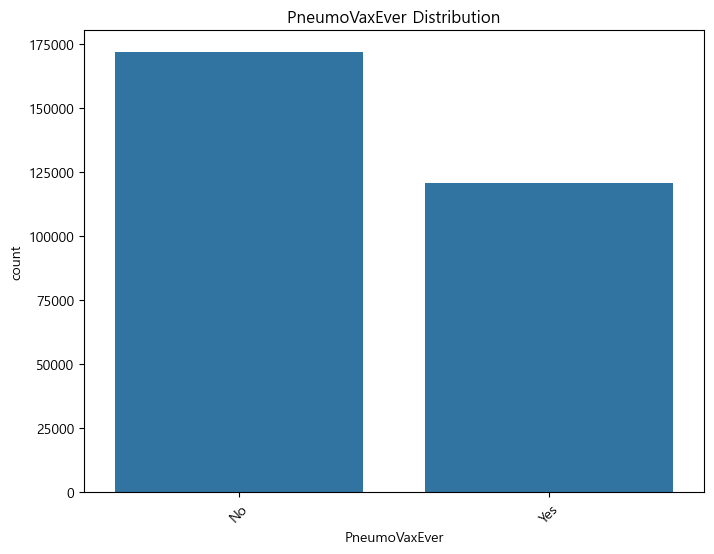

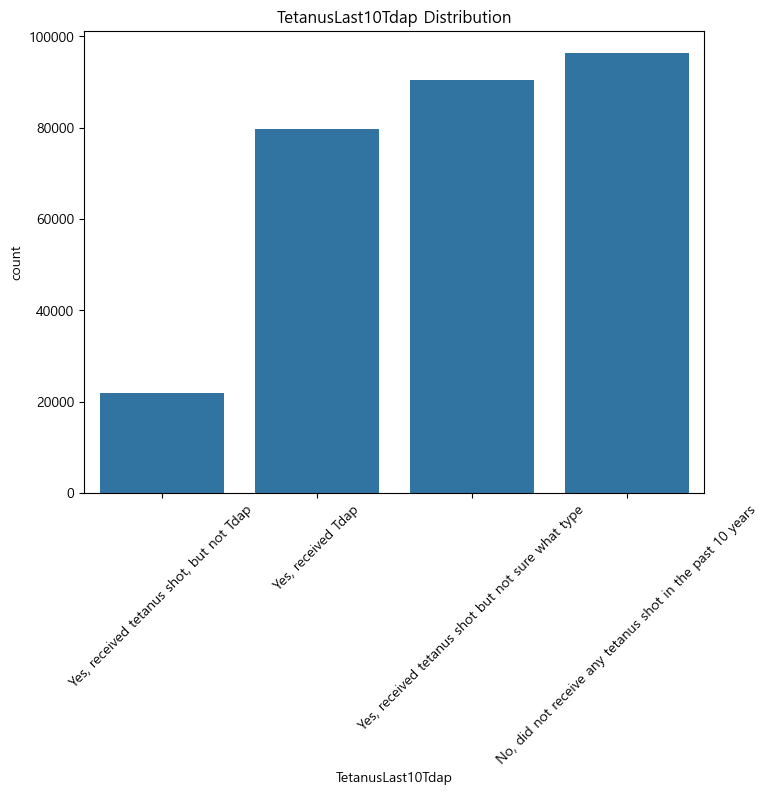

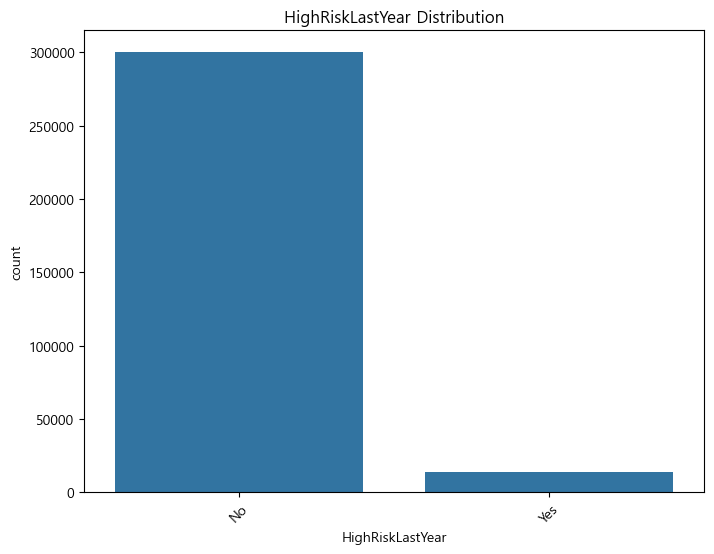

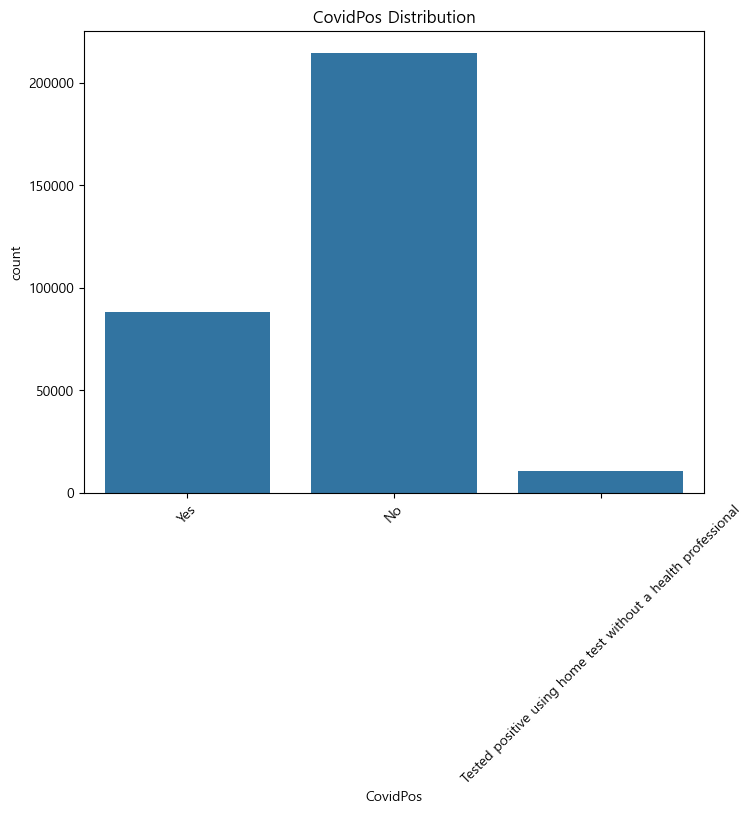

In [6]:
# 범주형 변수의 빈도 시각화
categorical_cols = train.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=train, x=col)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    plt.show()

# 파이프라인으로 전처리

In [4]:
from sklearn.pipeline import Pipeline  # 파이프라인 생성
from sklearn.compose import ColumnTransformer  # 컬럼별 전처리
from sklearn.base import BaseEstimator, TransformerMixin  # 사용자 정의 변환기

In [5]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # 매핑 딕셔너리 설정
        self.yes_or_no = {'No': 1, np.nan: 2, 'Yes': 3}
        self.region_mapping = {
            **dict.fromkeys(('Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut',
                             'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Delaware'), '북동부'),
            **dict.fromkeys(('Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida',
                             'Alabama', 'Tennessee', 'Kentucky', 'Mississippi', 'Arkansas',
                             'Louisiana', 'West Virginia'), '남동부'),
            **dict.fromkeys(('Michigan', 'Ohio', 'Indiana', 'Illinois', 'Iowa', 'Missouri',
                             'Kansas', 'Minnesota', 'Wisconsin', 'North Dakota',
                             'South Dakota', 'Nebraska'), '중서부'),
            **dict.fromkeys(('Montana', 'Wyoming', 'Idaho', 'Colorado', 'Utah', 'Nevada',
                             'Washington', 'Oregon', 'Alaska'), '북서부'),
            **dict.fromkeys(('California', 'Arizona', 'New Mexico', 'Texas', 'Oklahoma'), '남서부'),
            **dict.fromkeys(('Hawaii', 'Guam'), '태평양'),
            **dict.fromkeys(('Puerto Rico', 'Virgin Islands'), '카리브해'),
            'District of Columbia': '특수 구역'
        }
        self.reg_ord = {'북동부': 1, '북서부': 2, '태평양': 3, '중서부': 4, '남서부': 5, '남동부': 6, '카리브해': 7, '특수 구역': 8}
        self.sex_ord = {'Male': 1, 'Female': 2}
        self.gen_ord = {'Excellent': 1, 'Very good': 2, 'Good': 3, 'Fair': 4, 'Poor': 5}
        self.las_ord = {
            'Within past year (anytime less than 12 months ago)': 1,
            'Within past 2 years (1 year but less than 2 years ago)': 2,
            'Within past 5 years (2 years but less than 5 years ago)': 3,
            '5 or more years ago': 4
        }
        self.dia_ord = {
            'No': 1, 'No, pre-diabetes or borderline diabetes': 2,
            'Yes, but only during pregnancy (female)': 3, 'Yes': 4
        }
        self.rem_ord = {
            'None of them': 1, '1 to 5': 2, '6 or more, but not all': 3, 'All': 4,
            1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4
        }
        self.smo_ord = {
            'Never smoked': 1, 'Former smoker': 2,
            'Current smoker - now smokes some days': 3, 'Current smoker - now smokes every day': 4
        }
        self.eci_ord = {
            'Never used e-cigarettes in my entire life': 1, 'Not at all (right now)': 2,
            'Use them some days': 3, 'Use them every day': 4
        }
        self.tet_ord = {
            'No, did not receive any tetanus shot in the past 10 years': 1,
            'Yes, received tetanus shot but not sure what type': 2,
            'Yes, received tetanus shot, but not Tdap': 3, 'Yes, received Tdap': 4
        }
        self.cov_ord = {
            'No': 0,
            'Tested positive using home test without a health professional': 1,
            'Yes': 2
        }
        self.age_ord = {
            'Age 18 to 24': 1, 'Age 25 to 29': 2, 'Age 30 to 34': 3, 'Age 35 to 39': 4,
            'Age 40 to 44': 5, 'Age 45 to 49': 6, 'Age 50 to 54': 7, 'Age 55 to 59': 8,
            'Age 60 to 64': 9, 'Age 65 to 69': 10, 'Age 70 to 74': 11, 'Age 75 to 79': 12, 'Age 80 or older': 13
        }
        self.rac_ord = {
        'White only, Non-Hispanic': 1, 'Black only, Non-Hispanic': 2, 'Hispanic': 3,
        'Multiracial, Non-Hispanic': 4, 'Other race only, Non-Hispanic': 5
        }

    def fit(self, X, y=None):
        # 중앙값, 최빈값 등 결측치 대체 값 계산
        self.fill_values = {
            'SleepHours': X['SleepHours'].median(),
            'RemovedTeeth': X['RemovedTeeth'].fillna('None of them').mode()[0],
            'HadDiabetes': X['HadDiabetes'].mode()[0],
            'SmokerStatus': X['SmokerStatus'].mode()[0],
            'ECigaretteUsage': X['ECigaretteUsage'].mode()[0],
            'TetanusLast10Tdap': X['TetanusLast10Tdap'].mode()[0],
            'CovidPos': X['CovidPos'].mode()[0],
            'RaceEthnicityCategory': X['RaceEthnicityCategory'].mode()[0],
            'AgeCategory': X['AgeCategory'].mode()[0],
            'BMI': X['BMI'].mean(),
            'WeightInKilograms': X['WeightInKilograms'].mean(),
            'HeightInMeters': X['HeightInMeters'].mean(),
        }
        return self

    def transform(self, X):
        X = X.copy()

        # 결측값 대체
        X['SleepHours'].fillna(self.fill_values['SleepHours'], inplace=True)
        X['PhysicalHealthDays'].fillna(0, inplace=True)
        X['MentalHealthDays'].fillna(0, inplace=True)
        X['RemovedTeeth'] = X['RemovedTeeth'].fillna('None of them')
        X['HadDiabetes'].fillna(self.fill_values['HadDiabetes'], inplace=True)
        X['SmokerStatus'].fillna(self.fill_values['SmokerStatus'], inplace=True)
        X['ECigaretteUsage'].fillna(self.fill_values['ECigaretteUsage'], inplace=True)
        X['TetanusLast10Tdap'].fillna(self.fill_values['TetanusLast10Tdap'], inplace=True)
        X['CovidPos'].fillna(self.fill_values['CovidPos'], inplace=True)
        X['RaceEthnicityCategory'].fillna(self.fill_values['RaceEthnicityCategory'], inplace=True)
        X['AgeCategory'].fillna(self.fill_values['AgeCategory'], inplace=True)
        X['BMI'].fillna(self.fill_values['BMI'], inplace=True)
        X['HeightInMeters'].fillna(self.fill_values['HeightInMeters'], inplace=True)
        X['WeightInKilograms'].fillna(self.fill_values['WeightInKilograms'], inplace=True)

        # 매핑 처리
        X['State'] = X['State'].map(self.region_mapping).fillna(X['State'])
        X['State'] = X['State'].map(self.reg_ord).fillna(X['State'])
        X['Sex'] = X['Sex'].map(self.sex_ord).fillna(X['Sex'])
        X['GeneralHealth'] = X['GeneralHealth'].map(self.gen_ord).fillna(1)
        X['LastCheckupTime'] = X['LastCheckupTime'].map(self.las_ord).fillna(4)
        X['HadDiabetes'] = X['HadDiabetes'].map(self.dia_ord).fillna(self.fill_values['HadDiabetes'])
        X['RemovedTeeth'] = X['RemovedTeeth'].map(self.rem_ord).fillna(self.fill_values['RemovedTeeth'])
        X['SmokerStatus'] = X['SmokerStatus'].map(self.smo_ord).fillna(self.fill_values['SmokerStatus'])
        X['ECigaretteUsage'] = X['ECigaretteUsage'].map(self.eci_ord).fillna(self.fill_values['ECigaretteUsage'])
        X['TetanusLast10Tdap'] = X['TetanusLast10Tdap'].map(self.tet_ord).fillna(self.fill_values['TetanusLast10Tdap'])
        X['AgeCategory'] = X['AgeCategory'].map(self.age_ord).fillna(self.fill_values['AgeCategory'])
        X['CovidPos'] = X['CovidPos'].map(self.cov_ord).fillna(self.fill_values['CovidPos'])
        X['RaceEthnicityCategory'] = X['RaceEthnicityCategory'].map(self.rac_ord).fillna(6)

        # Yes/No 처리
        for col in ['PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma',
                    'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
                    'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
                    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
                    'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting',
                    'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear']:
            X[col] = X[col].map(self.yes_or_no).fillna(2)  # '모름'으로 설정

        return X



In [6]:
# 파이프라인 생성
pipeline = Pipeline([
    ('preprocessor', CustomPreprocessor()),
])

# train 데이터 변환
train = pipeline.fit_transform(train)

# test 데이터 변환
test = pipeline.transform(test)

C:\Users\user\AppData\Local\Temp\ipykernel_24852\1472689390.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['SleepHours'].fillna(self.fill_values['SleepHours'], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_24852\1472689390.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

# 파이프라인으로 대체했으니 실행하지 말아주세요!!

## State (완료) 1/40

In [4]:
# label encoding을 위한 dictionary
yes_or_no = {'No' : 1, np.nan : 2, 'Yes' : 3} # np.nan은 모름이라고 본다.

In [5]:
np.sort(train['State'].unique()) == np.sort(test['State'].unique())
# 모두 동일함

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [6]:
region_mapping = {
    **dict.fromkeys(('Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut',
                     'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Delaware'), '북동부'),
    **dict.fromkeys(('Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 
                     'Alabama', 'Tennessee', 'Kentucky', 'Mississippi', 'Arkansas', 
                     'Louisiana', 'West Virginia'), '남동부'),
    **dict.fromkeys(('Michigan', 'Ohio', 'Indiana', 'Illinois', 'Iowa', 'Missouri', 
                     'Kansas', 'Minnesota', 'Wisconsin', 'North Dakota', 
                     'South Dakota', 'Nebraska'), '중서부'),
    **dict.fromkeys(('Montana', 'Wyoming', 'Idaho', 'Colorado', 'Utah', 'Nevada', 
                     'Washington', 'Oregon', 'Alaska'), '북서부'),
    **dict.fromkeys(('California', 'Arizona', 'New Mexico', 'Texas', 'Oklahoma'), '남서부'),
    **dict.fromkeys(('Hawaii', 'Guam'), '태평양'),
    **dict.fromkeys(('Puerto Rico', 'Virgin Islands'), '카리브해'),
    'District of Columbia': '특수 구역'
}

train['State'] = train['State'].map(region_mapping).fillna(train['State'])
test['State'] = test['State'].map(region_mapping).fillna(test['State'])

reg_ord = {
    '북동부': 1, '북서부': 2, '태평양': 3, '중서부': 4,
    '남서부': 5, '남동부': 6, '카리브해': 7, '특수 구역': 8
}

train['State'] = train['State'].map(reg_ord).fillna(train['State'])
test['State'] = test['State'].map(reg_ord).fillna(test['State'])

## Sex (완료) 2/40

In [7]:
sex_ord = {'Male': 1, 'Female': 2}

train['Sex'] = train['Sex'].map(sex_ord).fillna(train['Sex'])
test['Sex'] = test['Sex'].map(sex_ord).fillna(test['Sex'])

## GeneralHealth (완료) 3/40

In [8]:
print('응답자가 스스로 몸이 괜찮다고 느껴서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 1로 설정')

gen_ord = {
    'Excellent': 1, 'Very good': 2, 'Good': 3, 
    'Fair': 4, 'Poor': 5
}

train['GeneralHealth'] = train['GeneralHealth'].map(gen_ord).fillna(1)
test['GeneralHealth'] = test['GeneralHealth'].map(gen_ord).fillna(1)

응답자가 스스로 몸이 괜찮다고 느껴서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 1로 설정


## PhysicalHealthDays (완료) 4/40 [선택받음]

In [9]:
print('응답자가 스스로 몸이 괜찮다고 느껴서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 0으로 설정')
train['PhysicalHealthDays'].fillna(0, inplace=True)
test['PhysicalHealthDays'].fillna(0, inplace=True)

응답자가 스스로 몸이 괜찮다고 느껴서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 0으로 설정


C:\Users\user\AppData\Local\Temp\ipykernel_29864\3782767723.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['PhysicalHealthDays'].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\3782767723.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

## MentalHealthDays (완료) 5/40 [선택받음]

In [10]:
print('응답자가 스스로 정신 이상을 느끼지 않아서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 0으로 설정')
train['MentalHealthDays'].fillna(0, inplace=True)
test['MentalHealthDays'].fillna(0, inplace=True)

응답자가 스스로 정신 이상을 느끼지 않아서 굳이 체크할 필요를 못 느꼈을 겁니다. 그러므로 결측치 0으로 설정


C:\Users\user\AppData\Local\Temp\ipykernel_29864\583267640.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['MentalHealthDays'].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\583267640.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

## LastCheckupTime (완료) 6/40

In [11]:
print('응답자가 기억 못 하는 거면 아마 아주 예전에 받았을 것이다.')
las_ord = {
    'Within past year (anytime less than 12 months ago)': 1, 'Within past 2 years (1 year but less than 2 years ago)': 2,
    'Within past 5 years (2 years but less than 5 years ago)': 3, '5 or more years ago': 4
}

train['LastCheckupTime'] = train['LastCheckupTime'].map(las_ord).fillna(4)
test['LastCheckupTime'] = test['LastCheckupTime'].map(las_ord).fillna(4)

응답자가 기억 못 하는 거면 아마 아주 예전에 받았을 것이다.


## PhysicalActivities (완료) 7/40

In [12]:
# label encoding
train['PhysicalActivities'] = train['PhysicalActivities'].map(yes_or_no).fillna(train['PhysicalActivities'])
test['PhysicalActivities'] = test['PhysicalActivities'].map(yes_or_no).fillna(test['PhysicalActivities'])

## SleepHours (완료) 8/40 [선택받음]

In [13]:
sle_med = train['SleepHours'].median()

# 출처: https://www.analyticsvidhya.com/blog/2022/07/an-accurate-approach-to-data-imputation/
train['SleepHours'].fillna(sle_med, inplace=True)
test['SleepHours'].fillna(sle_med, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\1853851801.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['SleepHours'].fillna(sle_med, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\1853851801.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

## RemovedTeeth (완료) 9/40

In [14]:
rem_ord = {
    'None of them': 1, '1 to 5': 2,
    '6 or more, but not all': 3, 'All': 4
}

train['RemovedTeeth'] = train['RemovedTeeth'].map(rem_ord).fillna(train['RemovedTeeth'])
test['RemovedTeeth'] = test['RemovedTeeth'].map(rem_ord).fillna(test['RemovedTeeth'])

rem_fre = train['RemovedTeeth'].mode()[0]

train['RemovedTeeth'] = train['RemovedTeeth'].fillna(rem_fre)
test['RemovedTeeth'] = test['RemovedTeeth'].fillna(rem_fre)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\3711696099.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['RemovedTeeth'] = train['RemovedTeeth'].map(rem_ord).fillna(train['RemovedTeeth'])
C:\Users\user\AppData\Local\Temp\ipykernel_29864\3711696099.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['RemovedTeeth'] = test['RemovedTeeth'].map(rem_ord).fillna(test['RemovedTeeth'])


## HadAngina (완료) 10/40

In [15]:
# label encoding
train['HadAngina'] = train['HadAngina'].map(yes_or_no).fillna(train['HadAngina'])
test['HadAngina'] = test['HadAngina'].map(yes_or_no).fillna(test['HadAngina'])

## HadStroke (완료) 11/40

In [16]:
# label encoding
train['HadStroke'] = train['HadStroke'].map(yes_or_no).fillna(train['HadStroke'])
test['HadStroke'] = test['HadStroke'].map(yes_or_no).fillna(test['HadStroke'])

## HadAsthma (완료) 12/40

In [17]:
# label encoding
train['HadAsthma'] = train['HadAsthma'].map(yes_or_no).fillna(train['HadAsthma'])
test['HadAsthma'] = test['HadAsthma'].map(yes_or_no).fillna(test['HadAsthma'])

## HadSkinCancer (완료) 13/40

In [18]:
# label encoding
train['HadSkinCancer'] = train['HadSkinCancer'].map(yes_or_no).fillna(train['HadSkinCancer'])
test['HadSkinCancer'] = test['HadSkinCancer'].map(yes_or_no).fillna(test['HadSkinCancer'])

## HadCOPD (완료) 14/40

In [19]:
# label encoding
train['HadCOPD'] = train['HadCOPD'].map(yes_or_no).fillna(train['HadCOPD'])
test['HadCOPD'] = test['HadCOPD'].map(yes_or_no).fillna(test['HadCOPD'])

## HadDepressiveDisorder (완료) 15/40

In [20]:
# label encoding
train['HadDepressiveDisorder'] = train['HadDepressiveDisorder'].map(yes_or_no).fillna(train['HadDepressiveDisorder'])
test['HadDepressiveDisorder'] = test['HadDepressiveDisorder'].map(yes_or_no).fillna(test['HadDepressiveDisorder'])

## HadKidneyDisease (완료) 16/40

In [21]:
# label encoding
train['HadKidneyDisease'] = train['HadKidneyDisease'].map(yes_or_no).fillna(train['HadKidneyDisease'])
test['HadKidneyDisease'] = test['HadKidneyDisease'].map(yes_or_no).fillna(test['HadKidneyDisease'])

## HadArthritis (완료) 17/40

In [22]:
# label encoding
train['HadArthritis'] = train['HadArthritis'].map(yes_or_no).fillna(train['HadArthritis'])
test['HadArthritis'] = test['HadArthritis'].map(yes_or_no).fillna(test['HadArthritis'])

## HadDiabetes (완료) 18/40

In [23]:
# label encoding
dia_ord = {
    'No': 1, 'No, pre-diabetes or borderline diabetes': 2,
    'Yes, but only during pregnancy (female)': 3, 'Yes': 4
}

train['HadDiabetes'] = train['HadDiabetes'].map(dia_ord).fillna(train['HadDiabetes'])
test['HadDiabetes'] = test['HadDiabetes'].map(dia_ord).fillna(test['HadDiabetes'])

dia_fre = train['HadDiabetes'].mode()[0]

train['HadDiabetes'] = train['HadDiabetes'].fillna(dia_fre)
test['HadDiabetes'] = test['HadDiabetes'].fillna(dia_fre)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\642571326.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['HadDiabetes'] = train['HadDiabetes'].map(dia_ord).fillna(train['HadDiabetes'])
C:\Users\user\AppData\Local\Temp\ipykernel_29864\642571326.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['HadDiabetes'] = test['HadDiabetes'].map(dia_ord).fillna(test['HadDiabetes'])


## DeafOrHardOfHearing (완료) 19/40

In [24]:
# label encoding
train['DeafOrHardOfHearing'] = train['DeafOrHardOfHearing'].map(yes_or_no).fillna(train['DeafOrHardOfHearing'])
test['DeafOrHardOfHearing'] = test['DeafOrHardOfHearing'].map(yes_or_no).fillna(test['DeafOrHardOfHearing'])

## BlindOrVisionDifficulty (완료) 20/40

In [25]:
# label encoding
train['BlindOrVisionDifficulty'] = train['BlindOrVisionDifficulty'].map(yes_or_no).fillna(train['BlindOrVisionDifficulty'])
test['BlindOrVisionDifficulty'] = test['BlindOrVisionDifficulty'].map(yes_or_no).fillna(test['BlindOrVisionDifficulty'])

## DifficultyConcentrating (완료) 21/40

In [26]:
# label encoding
train['DifficultyConcentrating'] = train['DifficultyConcentrating'].map(yes_or_no).fillna(train['DifficultyConcentrating'])
test['DifficultyConcentrating'] = test['DifficultyConcentrating'].map(yes_or_no).fillna(test['DifficultyConcentrating'])

## DifficultyWalking (완료) 22/40

In [27]:
# label encoding
train['DifficultyWalking'] = train['DifficultyWalking'].map(yes_or_no).fillna(train['DifficultyWalking'])
test['DifficultyWalking'] = test['DifficultyWalking'].map(yes_or_no).fillna(test['DifficultyWalking'])

## DifficultyDressingBathing (완료) 23/40

In [28]:
# label encoding
train['DifficultyDressingBathing'] = train['DifficultyDressingBathing'].map(yes_or_no).fillna(train['DifficultyDressingBathing'])
test['DifficultyDressingBathing'] = test['DifficultyDressingBathing'].map(yes_or_no).fillna(test['DifficultyDressingBathing'])

## DifficultyErrands (완료) 24/40

In [29]:
# label encoding
train['DifficultyErrands'] = train['DifficultyErrands'].map(yes_or_no).fillna(train['DifficultyErrands'])
test['DifficultyErrands'] = test['DifficultyErrands'].map(yes_or_no).fillna(test['DifficultyErrands'])

## SmokerStatus (완료) 25/40

In [30]:
smo_ord = {
    'Never smoked': 1, 'Former smoker': 2,
    'Current smoker - now smokes some days': 3, 'Current smoker - now smokes every day': 4
}

smo_fre = train['SmokerStatus'].mode()[0] 

train['SmokerStatus'].fillna(smo_fre, inplace=True)
test['SmokerStatus'].fillna(smo_fre, inplace=True)

train['SmokerStatus'] = train['SmokerStatus'].map(smo_ord).fillna(train['SmokerStatus'])
test['SmokerStatus'] = test['SmokerStatus'].map(smo_ord).fillna(test['SmokerStatus'])

print('결측치 비율이 45프로를 넘어서 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨')

결측치 비율이 45프로를 넘어서 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨


C:\Users\user\AppData\Local\Temp\ipykernel_29864\131210756.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['SmokerStatus'].fillna(smo_fre, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\131210756.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

## ECigaretteUsage (완료) 26/40

In [31]:
eci_ord = {
    'Never used e-cigarettes in my entire life': 1, 'Not at all (right now)': 2,
    'Use them some days': 3, 'Use them every day': 4
}

eci_fre = train['ECigaretteUsage'].mode()[0]

train['ECigaretteUsage'].fillna(eci_fre, inplace=True)
test['ECigaretteUsage'].fillna(eci_fre, inplace=True)

train['ECigaretteUsage'] = train['ECigaretteUsage'].map(eci_ord).fillna(train['ECigaretteUsage'])
test['ECigaretteUsage'] = test['ECigaretteUsage'].map(eci_ord).fillna(test['ECigaretteUsage'])

print('결측치 비율이 30프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨')

C:\Users\user\AppData\Local\Temp\ipykernel_29864\2814406633.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['ECigaretteUsage'].fillna(eci_fre, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\2814406633.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

결측치 비율이 30프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨


## ChestScan (완료) 27/40

In [32]:
# label encoding
train['ChestScan'] = train['ChestScan'].map(yes_or_no).fillna(train['ChestScan'])
test['ChestScan'] = test['ChestScan'].map(yes_or_no).fillna(test['ChestScan'])

## RaceEthnicityCategory (완료) 28/40

In [33]:
print('결측치가 생각보다 많아서 모름(6)으로 인코딩함')
rac_ord = {
    'White only, Non-Hispanic': 1, 'Black only, Non-Hispanic': 2, 'Hispanic': 3,
    'Multiracial, Non-Hispanic': 4, 'Other race only, Non-Hispanic': 5, np.nan: 6
}

train['RaceEthnicityCategory'] = train['RaceEthnicityCategory'].map(rac_ord).fillna(train['RaceEthnicityCategory'])
test['RaceEthnicityCategory'] = test['RaceEthnicityCategory'].map(rac_ord).fillna(train['RaceEthnicityCategory'])

결측치가 생각보다 많아서 모름(6)으로 인코딩함


## AgeCategory (완료) 29/40

In [34]:
age_ord = {
    'Age 18 to 24': 1, 'Age 25 to 29': 2, 'Age 30 to 34': 3, 'Age 35 to 39': 4,
    'Age 40 to 44': 5, 'Age 45 to 49': 6, 'Age 50 to 54': 7, 'Age 55 to 59': 8,
    'Age 60 to 64': 9, 'Age 65 to 69': 10, 'Age 70 to 74': 11, 'Age 75 to 79': 12, 'Age 80 or older': 13
}

age_fre = train['AgeCategory'].mode()[0]

train['AgeCategory'].fillna(age_fre, inplace=True)
test['AgeCategory'].fillna(age_fre, inplace=True)

train['AgeCategory'] = train['AgeCategory'].map(age_ord).fillna(train['AgeCategory'])
test['AgeCategory'] = test['AgeCategory'].map(age_ord).fillna(test['AgeCategory'])

print('결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨')

결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨


C:\Users\user\AppData\Local\Temp\ipykernel_29864\2373265112.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['AgeCategory'].fillna(age_fre, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\2373265112.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

## HeightInMeters (완료) 30/40

In [35]:
hei_mea = train['HeightInMeters'].mean()

train['HeightInMeters'].fillna(hei_mea, inplace=True)
test['HeightInMeters'].fillna(hei_mea, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\3676775325.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['HeightInMeters'].fillna(hei_mea, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\3676775325.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

## WeightInKilograms (완료) 31/40

In [36]:
wei_mea = train['WeightInKilograms'].mean()

train['WeightInKilograms'].fillna(wei_mea, inplace=True)
test['WeightInKilograms'].fillna(wei_mea, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\2145587562.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['WeightInKilograms'].fillna(wei_mea, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\2145587562.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

## BMI (완료) 32/40

In [37]:
bmi_mea = train['BMI'].mean()

train['BMI'].fillna(bmi_mea, inplace=True)
test['BMI'].fillna(bmi_mea, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29864\3977056327.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['BMI'].fillna(bmi_mea, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\3977056327.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

## AlcoholDrinkers (완료) 33/40

In [38]:
# label encoding
train['AlcoholDrinkers'] = train['AlcoholDrinkers'].map(yes_or_no).fillna(train['AlcoholDrinkers'])
test['AlcoholDrinkers'] = test['AlcoholDrinkers'].map(yes_or_no).fillna(test['AlcoholDrinkers'])

## HIVTesting (완료) 34/40

In [39]:
# label encoding
train['HIVTesting'] = train['HIVTesting'].map(yes_or_no).fillna(train['HIVTesting'])
test['HIVTesting'] = test['HIVTesting'].map(yes_or_no).fillna(test['HIVTesting'])

## FluVaxLast12 (완료) 35/40

In [40]:
# label encoding
train['FluVaxLast12'] = train['FluVaxLast12'].map(yes_or_no).fillna(train['FluVaxLast12'])
test['FluVaxLast12'] = test['FluVaxLast12'].map(yes_or_no).fillna(test['FluVaxLast12'])

## PneumoVaxEver (완료) 36/40

In [41]:
# label encoding
train['PneumoVaxEver'] = train['PneumoVaxEver'].map(yes_or_no).fillna(train['PneumoVaxEver'])
test['PneumoVaxEver'] = test['PneumoVaxEver'].map(yes_or_no).fillna(test['PneumoVaxEver'])

## TetanusLast10Tdap (완료) 37/40

In [42]:
tet_ord = {
    'No, did not receive any tetanus shot in the past 10 years': 1, 'Yes, received tetanus shot but not sure what type': 2,
    'Yes, received tetanus shot, but not Tdap': 3, 'Yes, received Tdap': 4
}

tet_fre = train['TetanusLast10Tdap'].mode()[0]

train['TetanusLast10Tdap'].fillna(tet_fre, inplace=True)
test['TetanusLast10Tdap'].fillna(tet_fre, inplace=True)

train['TetanusLast10Tdap'] = train['TetanusLast10Tdap'].map(tet_ord).fillna(train['TetanusLast10Tdap'])
test['TetanusLast10Tdap'] = test['TetanusLast10Tdap'].map(tet_ord).fillna(test['TetanusLast10Tdap'])

print('결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨')

결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨


C:\Users\user\AppData\Local\Temp\ipykernel_29864\3705039623.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['TetanusLast10Tdap'].fillna(tet_fre, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\3705039623.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

## HighRiskLastYear (완료) 38/40

In [43]:
# label encoding
train['HighRiskLastYear'] = train['HighRiskLastYear'].map(yes_or_no).fillna(train['HighRiskLastYear'])
test['HighRiskLastYear'] = test['HighRiskLastYear'].map(yes_or_no).fillna(test['HighRiskLastYear'])

## CovidPos (완료) 39/40

In [44]:
# label encoding
cov_ord = {
    'No': 0,
    'Tested positive using home test without a health professional': 1, 'Yes': 2
}

cov_fre = train['CovidPos'].mode()[0]

train['CovidPos'].fillna(cov_fre, inplace=True)
test['CovidPos'].fillna(cov_fre, inplace=True)

train['CovidPos'] = train['CovidPos'].map(cov_ord).fillna(train['CovidPos'])
test['CovidPos'] = test['CovidPos'].map(cov_ord).fillna(test['CovidPos'])

print('결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨')

결측치 비율이 20프로를 넘어서 그냥 삭제하기로 결정했는데 그럼 행의 개수가 달라져서 submission에 저장 안 됨


C:\Users\user\AppData\Local\Temp\ipykernel_29864\302893907.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['CovidPos'].fillna(cov_fre, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29864\302893907.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

## 결과: HadHeartAttack 40/40

In [45]:
train['HadHeartAttack'].value_counts()

HadHeartAttack
0    333567
1     20086
Name: count, dtype: int64

In [46]:
'''
train_num = train[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']]
test_num = test[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']]

num = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

fig, axes = plt.subplots(nrows=len(num), ncols=1, figsize=(6, 10), constrained_layout=True)

for i, feature in enumerate(num):
    sns.kdeplot(data=train_num[feature], ax=axes[i], label='Train')
    sns.kdeplot(data=test_num[feature], ax=axes[i], label='Test')
    axes[i].legend()

plt.show()
'''

"\ntrain_num = train[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']]\ntest_num = test[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']]\n\nnum = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']\n\nfig, axes = plt.subplots(nrows=len(num), ncols=1, figsize=(6, 10), constrained_layout=True)\n\nfor i, feature in enumerate(num):\n    sns.kdeplot(data=train_num[feature], ax=axes[i], label='Train')\n    sns.kdeplot(data=test_num[feature], ax=axes[i], label='Test')\n    axes[i].legend()\n\nplt.show()\n"

# Feature를 selection하거나 extraction하자

In [7]:
tr = (train.isnull().sum() / train.shape[0]) * 100
te = (test.isnull().sum() / test.shape[0]) * 100

pd.concat([tr, te], axis=1, keys=['train 결측치', 'test 결측치'])

,train 결측치,test 결측치
ID,0.0,0.0
State,0.0,0.0
Sex,0.0,0.0
GeneralHealth,0.0,0.0
PhysicalHealthDays,0.0,0.0
MentalHealthDays,0.0,0.0
LastCheckupTime,0.0,0.0
PhysicalActivities,0.0,0.0
SleepHours,0.0,0.0
RemovedTeeth,0.0,0.0


# klib 써서 상관계수 파악하자
(근데 y_train이 범주형이라서 상관계수 쓰는 거 별로임)

In [8]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 그러므로 Kruskal-Wallis H 검정[수치형]이랑 Fisher's Exact Tes[범주형] 씀

In [28]:
X = train.drop(columns=['HadHeartAttack'])
y = train['HadHeartAttack']

In [11]:
# 수치형 데이터
X_num = X[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']]

# 범주형 변수 (나머지 변수들)
X_cat = X.drop(columns=['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI'])

print('수치형은 anova, 범주형은 chi-square\n')
print('근데, anova와 chi-square은 데이터셋이 커지면 성능이 안 좋으니까,\n수치형엔 Kruskal-Wallis H 검정을 쓰고 범주형엔 Fisher\'s Exact Test을 쓸 거다.')
print('Kruskal-Wallis H 검정과  Fisher\'s Exact Test은 비모수적(샘플링) 방법이므로, 채택하겠다')

수치형은 anova, 범주형은 chi-square

근데, anova와 chi-square은 데이터셋이 커지면 성능이 안 좋으니까,
수치형엔 Kruskal-Wallis H 검정을 쓰고 범주형엔 Fisher's Exact Test을 쓸 거다.
Kruskal-Wallis H 검정과  Fisher's Exact Test은 비모수적(샘플링) 방법이므로, 채택하겠다


In [14]:
from imblearn.under_sampling import TomekLinks
from scipy.stats import kruskal, chi2_contingency

# 유의수준 설정
alpha = 0.05

# 샘플링 (1%) 3,000개의 데이터셋
sample_size_ratio = 0.01
sampled_data = X.sample(frac=sample_size_ratio, random_state=1004)

# 샘플링된 데이터셋에 대응되는 y 값 추가
sampled_y = y.loc[sampled_data.index]

# TomekLinks 적용
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(sampled_data, sampled_y)

# 선택된 수치형 변수 리스트
selected_num_features = []

# Kruskal-Wallis H 검정 (수치형 데이터)
for col in X_num.columns:  # X_num에 대해 직접 처리
    # 그룹화된 데이터로 Kruskal-Wallis H 검정
    groups = [X_resampled[X_resampled[col] == val][col].values for val in X_resampled[col].unique()]
    stat, p_value = kruskal(*groups)
    
    # p-value가 유의수준보다 작으면 수치형 피쳐 선택
    if p_value < alpha:
        selected_num_features.append(col)
    print(f'{col}에 대한 Kruskal-Wallis H 검정 결과 - p-value: {p_value}')

print()  # 띄어쓰기

# 선택된 범주형 변수 리스트
selected_cat_features = []

# 범주형 변수 (라벨 인코딩이 완료된 변수들)에 대해 Chi-Square 검정
for col in X_cat.columns:  # X_cat에 대해 직접 처리
    contingency_table = pd.crosstab(X_resampled[col], y_resampled)
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # p-value가 유의수준보다 작으면 범주형 피쳐 선택
    if p_value < alpha:
        selected_cat_features.append(col)
    print(f'{col}에 대한 Chi-Square 검정 결과 - p-value: {p_value}')

print()  # 띄어쓰기

# 최종 선택된 피쳐들 출력
print(f'\n선택된 수치형 피쳐들: {selected_num_features}')
print(f'선택된 범주형 피쳐들: {selected_cat_features}')

PhysicalHealthDays에 대한 Kruskal-Wallis H 검정 결과 - p-value: 0.0
MentalHealthDays에 대한 Kruskal-Wallis H 검정 결과 - p-value: 0.0
SleepHours에 대한 Kruskal-Wallis H 검정 결과 - p-value: 0.0
HeightInMeters에 대한 Kruskal-Wallis H 검정 결과 - p-value: 0.0
WeightInKilograms에 대한 Kruskal-Wallis H 검정 결과 - p-value: 0.0
BMI에 대한 Kruskal-Wallis H 검정 결과 - p-value: 8.919787880890595e-279

ID에 대한 Chi-Square 검정 결과 - p-value: 0.49195209943163054
State에 대한 Chi-Square 검정 결과 - p-value: 0.5805145744825765
Sex에 대한 Chi-Square 검정 결과 - p-value: 7.617426579970585e-05
GeneralHealth에 대한 Chi-Square 검정 결과 - p-value: 7.105751008073678e-31
LastCheckupTime에 대한 Chi-Square 검정 결과 - p-value: 2.6441195498666185e-07
PhysicalActivities에 대한 Chi-Square 검정 결과 - p-value: 6.7866243221742816e-06
RemovedTeeth에 대한 Chi-Square 검정 결과 - p-value: 1.0511401714583253e-19
HadAngina에 대한 Chi-Square 검정 결과 - p-value: 5.337703344227423e-137
HadStroke에 대한 Chi-Square 검정 결과 - p-value: 1.88608815497423e-33
HadAsthma에 대한 Chi-Square 검정 결과 - p-value: 0.21566032272989882
Had

In [15]:
# 수치형 데이터에서 선택되지 않은 피쳐들
num_features_not_selected_list = [col for col in X_num.columns if col not in selected_num_features]

# 범주형 데이터에서 선택되지 않은 피쳐들
cat_features_not_selected_list = [col for col in X_cat.columns if col not in selected_cat_features]

# 출력
print(f'선택되지 않은 수치형 피쳐들: {num_features_not_selected_list}')
print(f'선택되지 않은 범주형 피쳐들: {cat_features_not_selected_list}')

선택되지 않은 수치형 피쳐들: []
선택되지 않은 범주형 피쳐들: ['ID', 'State', 'HadAsthma', 'HadDepressiveDisorder', 'DifficultyConcentrating', 'ECigaretteUsage', 'RaceEthnicityCategory', 'HIVTesting', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


# 다중공산성 제거

In [17]:
threshold = 0.7

num_data = X_num
correlation_matrix = num_data.corr()

to_remove = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_remove.add(colname)
            
num_data_cleaned = num_data.drop(columns=to_remove)
num_mul = num_data_cleaned.columns.tolist()
X_num = num_mul

In [18]:
selected_num_features = X_num

In [19]:
X_selected = X[selected_num_features + selected_cat_features]
y_selected = y

X_train, X_val, y_train, y_val = train_test_split(X_selected, y_selected, test_size=0.2, random_state=1004)

In [20]:
X_selected

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,...,BlindOrVisionDifficulty,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ChestScan,AgeCategory,AlcoholDrinkers,FluVaxLast12,PneumoVaxEver
0,0.0,0.0,7.0,2.010000,85.730000,1,1.0,4.0,3,2,...,1,1,1,1,1,1,4,1,3,1
1,2.0,0.0,9.0,1.780000,77.110000,2,2.0,1.0,3,1,...,1,1,1,1,1,1,2,3,3,1
2,0.0,0.0,8.0,1.680000,89.810000,1,3.0,1.0,3,2,...,1,1,1,1,4,3,8,3,3,3
3,1.0,1.0,7.0,1.650000,68.040000,2,2.0,1.0,3,1,...,3,1,1,1,2,1,1,3,1,3
4,0.0,0.0,7.0,1.730000,81.650000,2,3.0,1.0,3,1,...,1,1,1,1,2,2,5,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353648,0.0,2.0,7.0,1.702953,83.076392,2,2.0,1.0,3,1,...,2,2,2,2,1,2,13,2,2,2
353649,0.0,0.0,7.0,1.650000,52.160000,2,1.0,1.0,3,1,...,1,1,1,1,1,1,4,3,3,1
353650,2.0,0.0,7.0,1.700000,118.840000,1,3.0,1.0,3,2,...,1,3,1,1,2,3,13,1,3,3
353651,30.0,0.0,5.0,1.650000,68.040000,1,5.0,1.0,1,3,...,1,3,1,1,1,1,10,1,3,3


In [21]:
X_train

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,...,BlindOrVisionDifficulty,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ChestScan,AgeCategory,AlcoholDrinkers,FluVaxLast12,PneumoVaxEver
242524,0.0,0.0,6.0,1.910000,136.080000,1,3.0,1.0,3,1,...,1,1,1,1,2,3,6,3,1,1
150644,0.0,0.0,7.0,1.702953,83.076392,1,3.0,1.0,3,1,...,2,2,2,2,1,2,7,2,2,2
127341,5.0,0.0,8.0,1.750000,131.540000,2,4.0,1.0,1,2,...,1,3,1,1,1,3,9,1,3,3
143102,0.0,0.0,8.0,1.700000,56.700000,1,1.0,1.0,3,1,...,1,1,1,1,1,3,10,1,1,1
188099,30.0,4.0,6.0,1.700000,136.080000,2,5.0,1.0,3,1,...,1,3,3,3,1,3,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173295,14.0,2.0,7.0,1.702953,83.076392,2,2.0,1.0,3,1,...,2,2,2,2,1,2,3,2,2,2
13637,0.0,0.0,8.0,1.570000,86.180000,2,3.0,1.0,3,1,...,1,1,1,1,1,1,10,1,1,3
217119,30.0,0.0,4.0,1.630000,65.770000,2,3.0,1.0,1,4,...,1,3,1,3,3,3,10,1,3,3
240139,0.0,0.0,8.0,1.780000,86.180000,1,2.0,1.0,3,2,...,1,1,1,1,2,1,13,3,3,3


In [22]:
X_val

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,...,BlindOrVisionDifficulty,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ChestScan,AgeCategory,AlcoholDrinkers,FluVaxLast12,PneumoVaxEver
159096,0.0,0.0,5.0,1.88,88.45,1,1.0,4.0,3,1,...,1,1,1,1,4,3,8,3,3,3
116115,0.0,0.0,7.0,1.60,49.44,2,2.0,4.0,3,1,...,1,1,1,1,1,1,3,3,1,1
275137,2.0,30.0,2.0,1.57,76.66,2,2.0,1.0,3,1,...,1,1,1,1,1,1,4,1,3,1
157208,0.0,20.0,5.0,1.83,113.40,1,5.0,1.0,1,2,...,1,3,1,1,2,3,5,3,1,1
174344,0.0,0.0,7.0,1.68,49.90,2,3.0,1.0,1,4,...,3,3,1,1,4,3,10,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9580,0.0,0.0,6.0,1.55,63.50,2,1.0,1.0,3,2,...,1,1,1,1,1,1,12,3,3,3
27426,15.0,0.0,6.0,1.52,108.41,2,3.0,1.0,3,3,...,1,1,1,2,1,2,5,2,2,2
265391,0.0,10.0,5.0,1.73,81.65,2,3.0,3.0,3,2,...,1,1,1,1,1,1,4,3,3,1
326765,0.0,0.0,8.0,1.83,111.13,1,2.0,1.0,3,2,...,1,1,1,1,1,3,11,1,1,3


In [23]:
y_train

242524    0
150644    0
127341    0
143102    0
188099    0
         ..
173295    0
13637     0
217119    0
240139    0
48130     0
Name: HadHeartAttack, Length: 282922, dtype: int64

In [24]:
y_val

159096    0
116115    0
275137    0
157208    1
174344    0
         ..
9580      0
27426     0
265391    0
326765    0
337519    0
Name: HadHeartAttack, Length: 70731, dtype: int64

# Preprocessing을 잘 완수했으니 Model Training을 해야겠지??

In [25]:
from xgboost import XGBClassifier

# 모델링
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

#  But, 과적합이 심한 큰 max_depth=9, 작은 reg_lambda=2.49486e-05 제거
model = XGBClassifier(random_state=1004, 
                      use_label_encoder=False, 
                      eval_metric='auc',
                      scale_pos_weight=16.6, 
                      learning_rate=0.1317968879910978, 
                      n_estimators=262, 
                      subsample=0.6504406802794592, 
                      colsample_bytree=0.6158190406566091, 
                      gamma=4.899528945810752, 
                      reg_alpha=0.00999690770970806)

# 모델적용
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

accuracy

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.844410513070648

# submission에 옮기기

In [27]:
X_test = test.drop(columns=['ID'])
X_test = X_test[X_train.columns]

predictions = model.predict(X_test)
p = pd.DataFrame(predictions)
p.value_counts()

0
0    71897
1    16517
Name: count, dtype: int64

In [225]:
submission['HadHeartAttack'] = predictions
submission['ID'] = test['ID']

submission.to_csv('submission.csv', index=False)